# Table of Contents
* [Extract Traits from the VertNet Database](#Extract-Traits-from-the-VertNet-Database)
	* [Introduction](#Introduction)
		* [General Approach](#General-Approach)
		* [Setup Steps to Run](#Setup-Steps-to-Run)
		* [Constants](#Constants)
		* [Look at Words in Target Cells](#Look-at-Words-in-Target-Cells)
		* [Regular Expression Objects](#Regular-Expression-Objects)
	* [Sex Parsing](#Sex-Parsing)
		* [Sex Parsing Regular Expression Battery](#Sex-Parsing-Regular-Expression-Battery)
		* [Test Sex Parsing](#Test-Sex-Parsing)
	* [Life Stage Parsing](#Life-Stage-Parsing)
		* [Life Stage Parsing Regular Expression Battery](#Life-Stage-Parsing-Regular-Expression-Battery)
		* [Test Life Stage Parsing](#Test-Life-Stage-Parsing)
	* [Common Regular Expression Fragments for Length and Mass Trait Parsing](#Common-Regular-Expression-Fragments-for-Length-and-Mass-Trait-Parsing)
	* [Total Length Parsing](#Total-Length-Parsing)
		* [Common Total Length Parsing Regular Expression Fragments](#Common-Total-Length-Parsing-Regular-Expression-Fragments)
		* [Total Length Parsing Regular Expression Battery](#Total-Length-Parsing-Regular-Expression-Battery)
		* [Test Total Length Parsing](#Test-Total-Length-Parsing)
	* [Body Mass Parsing](#Body-Mass-Parsing)
		* [Common Body Mass Parsing Regular Expression Fragments](#Common-Body-Mass-Parsing-Regular-Expression-Fragments)
		* [Body Mass Parsing Regular Expression Battery](#Body-Mass-Parsing-Regular-Expression-Battery)
		* [Test Body Mass Parsing](#Test-Body-Mass-Parsing)
	* [Extract Traits](#Extract-Traits)
		* [Extract Raw Trait Values](#Extract-Raw-Trait-Values)
		* [Look at Extracted Keys and Units](#Look-at-Extracted-Keys-and-Units)
		* [Conversion Factors for Total Length and Body Mass Traits](#Conversion-Factors-for-Total-Length-and-Body-Mass-Traits)
		* [Normalize Total Length and Body Mass Traits](#Normalize-Total-Length-and-Body-Mass-Traits)
	* [Assign Groups and Binomial Names](#Assign-Groups-and-Binomial-Names)
		* [Assign Each Record with an Extract to a Group](#Assign-Each-Record-with-an-Extract-to-a-Group)
		* [Read Externally Provided Group Assignments](#Read-Externally-Provided-Group-Assignments)
		* [Assign Groups and Binomial Names to All Records with an Extracted Trait](#Assign-Groups-and-Binomial-Names-to-All-Records-with-an-Extracted-Trait)
	* [Summarize Results](#Summarize-Results)
		* [Count Total Number of Extracts for Each Group](#Count-Total-Number-of-Extracts-for-Each-Group)
		* [Gather Counts by Species](#Gather-Counts-by-Species)
		* [Summarize Counts by Species within Each Group](#Summarize-Counts-by-Species-within-Each-Group)
		* [Get the Species with Most Counts within Each Group](#Get-the-Species-with-Most-Counts-within-Each-Group)
		* [Get Species Count Summary](#Get-Species-Count-Summary)
		* [Plot the Summaries as Stacked Bar Charts](#Plot-the-Summaries-as-Stacked-Bar-Charts)
		* [Plot the Summaries as Pie charts](#Plot-the-Summaries-as-Pie-charts)


# Extract Traits from the VertNet Database

## Introduction

**Welcome to the thrilling world of parsing irregularly structured text!**

We're going to extract the following traits from an extract of the [VertNet database](http://vertnet.org/):
- Sex
- Life stage
- Total length (or a commonly used measure often substituted for total length: E.g. Snout-Vent Length)
- Body mass (look for common body mass substitutes too)

We are looking for the traits in these columns of the VertNet database:
- dynamicproperties (This will be the preferred column for extracting values)
- occurrenceremarks
- fieldnotes

We will append the extracted data to new columns in each row.

We're exploiting the fact that most of the data is in a structured or semi-structured format.

**Note**: This an early version and, as such, it uses an *Ad hoc* approach with regular expressions. **This will not scale to other trait extractions.** We will need to use additional techniques for this.

### General Approach

We are going to loop through a each row in the CSV file and scan for the trait in each of the column cells. The scanning will involve an ordered battery of regular expressions for each trait. Once a trait is found for the CSV cell we will stop scanning that particular cell for the trait and move on to the next cell.  That means that we may find the same trait for a row in each of the scanned cells. For example: We may find a sex in both dynamicproperties and occurrenceremarks and we will record both. Once we have scanned all cells in a row for a trait we will then move on to scan all cells in the row for the next trait. And so on.  **The order of the regular expressions is important.**

We will add a new column for each trait being extracted. That column will contain a JSON object with an array of objects like so:

<table>
    <tr>
        <th>...rest of CSV row...</th>
        <th>autoextract_body_length</th>
        <th>...other extracted columns...</th>
    </tr>
    <tr>
        <td>orginal data is untouched</td>
        <td>{"dynamicproperties":{"key":"totalLengthInMM","units":"MM","value":"270"},
        "fieldnotes":{"key":"total length","units":"mm","value":"270.0"}}</td>
        <td>other extracted data</td>
    </tr>
    
</table>

The object will have the column we extracted the trait from as a column key. Therefore, there will be up to three fields in the object (In the example above there was nothing for the "occurrenceremarks" column.):
- key: AKA the regex key. (Two keys are a bit confusing.) This is what we're looking for to extract the value.
- value: This is a number or a number range for the value. Or a word or phrase for class values.
- units: For measurements with numbers we also try to extract the units associated with the value.

**Note**: We do not try to interpret any of the values while extracting them. We will interpret the data at a later step.

In [1]:
%matplotlib inline
import os
import sys
import csv
import json
import unittest
from collections import Counter
import regex   # re expressions lack desired features
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

### Setup Steps to Run

This notebook is used to explore a few traits in a VertNet extract. Typically, it is used interactively and iteratively to  explore the data and refine the algorithms. As we work through this process we will not want to run the entire notebook. Here is where we turn on or off the various parts of the notebook to run. Setup the options here and run all of the cells below this point.

In [2]:
RUN = {
    'Look at the Words in Target Cells'             : False,
    'Extract Raw Trait Values'                      : False,
    'Look at Extracted Keys and Units'              : False,
    'Normalize Total Length and Body Mass Traits'   : False,
    'Assign Groups and Binomial Names'              : False,
    'Count Total Number of Extracts for Each Group' : False,
    'Gather Counts by Species'                      : False,
    'Summarize Counts by Species within Each Group' : False,
    'Plot Summaries'                                : False,
}

### Constants

In [3]:
# data directory
DATA_DIR = '../data/'

# The file containing the original VertNet extraction
VERTNET_FILE_NAME = os.path.join(DATA_DIR, 'vn_20151028_orems_fnotes_dprops_not_null')

# Used in file names
# now = datetime.datetime.now().strftime("_%Y%m%d_%H%M_")
BASE_FILE_NAME = VERTNET_FILE_NAME + '_'

# The file containing the parsed VertNet traits
RAW_FILE_NAME = BASE_FILE_NAME + 'raw.csv'

# The file containing the normalized VertNet traits
NORMALIZED_FILE_NAME = BASE_FILE_NAME + 'norm.csv'

# The file containing the normalized VertNet traits
GROUPED_FILE_NAME = BASE_FILE_NAME + 'grouped.csv'

# A file containing all of the raw words in the target columns -- used to search for stem words
WORDS_FILE_NAME = BASE_FILE_NAME + 'words.txt'

# We will search these VerNet columns to extract the traits
# We use the order during normalization
VERTNET_SEARCH_COLUMNS = [
    'dynamicproperties',
    'occurrenceremarks',
    'fieldnotes'
]

[top](#Table-of-Contents)

### Look at Words in Target Cells

To get an idea of what kinds of data are in the cells we will look at the different words in the cells. After examining those words, we can start to get an idea of what regular expressions to write and which words to use as anchors for the regular expressions.

In [4]:
def get_words_in_cells(csv_dict_reader, search_columns):
    # For this, we consider dots as letters
    punctuation = regex.compile(r'[^\p{Letter}.]+')
    
    words = Counter()
    
    for row in csv_dict_reader:
        extracted_words = []
        
        for column in search_columns:
            extracted_words.extend(punctuation.split(row[column]))
    
        for word in extracted_words:
            words[word.lower()] += 1
    
    return sorted(words.keys())

In [5]:
def get_all_words():
    with open(VERTNET_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        words = get_words_in_cells(reader
                                   , VERTNET_SEARCH_COLUMNS)

    with open(WORDS_FILE_NAME, 'w') as out_file:
        for word in words:
            out_file.write(word + '\n')


if RUN['Look at the Words in Target Cells']:
    get_all_words()

### Regular Expression Objects

The regular expressions require common supporting logic so they are packaged into an object. We will use an array of these objects for the actual parsing.

In [6]:
class Regexp:
    def __init__(self, name, regexp,
                 want_array=0,
                 parse_units=False,
                 default_key=None,
                 default_units=None,
                 units_from_key=None,
                 tests=[]):
        self.name   = name
        self.tests  = tests
        self.regexp = regex.compile(regexp, regex.IGNORECASE | regex.VERBOSE)
        self.want_array     = want_array
        self.parse_units    = parse_units
        self.default_key    = default_key
        self.default_units  = default_units
        self.units_from_key = units_from_key

    def _get_key_(self, match):
        key = None
        if 'key' in match.groupdict().keys():
            key = match.group('key')
        if not key:
            key = self.default_key
        return key

    def _get_value_(self, match):
        if 'value' in match.groupdict().keys():
            return match.group('value')
        return [match.group('value1'), match.group('value2')]

    def _get_units_(self, match, key):
        units = None
        if 'units' in match.groupdict().keys():
            units = match.group('units')
        if 'units1' in match.groupdict().keys():
            units = [match.group('units1'), match.group('units2')]
        if not units and key:
            u = self.units_from_key.search(key)
            if u:
                units = u.group('units')
        if not units:
            units = self.default_units
        return units

    def _get_value_array_(self, string):
        matches = self.regexp.findall(string)
        if matches and len(matches) <= self.want_array:
            return dict(key=None, value=matches)
        else:
            return None

    def matches(self, string):
        if self.want_array:
            return self._get_value_array_(string)

        match = self.regexp.search(string)
        if not match:
            return None

        parsed = dict()
        parsed['key']   = self._get_key_(match)
        parsed['value'] = self._get_value_(match)
        if self.parse_units:
            parsed['units'] = self._get_units_(match, parsed['key'])

        return parsed

We use a carefully ordered array of regular expressions to look for traits in the database. There is some logic for dealing with the entire array of regular expressions, this is captured in the following object.

In [7]:
class RegexpBattery:
    def __init__(self, exclude_pattern=None, parse_units=False, units_from_key=None):
        self.exclude_pattern = exclude_pattern
        if exclude_pattern:
            self.exclude_pattern = regex.compile(
                exclude_pattern,
                regex.IGNORECASE | regex.VERBOSE)

        self.units_from_key = units_from_key
        if units_from_key:
            self.units_from_key = regex.compile(
                units_from_key,
                regex.IGNORECASE | regex.VERBOSE)

        self.battery     = []
        self.parse_units = parse_units

    def _excluded_(self, match):
        if self.exclude_pattern and match and isinstance(match['value'], str):
            return self.exclude_pattern.search(match['value'])
        return False
    
    def append(self, *args, **kwargs):
        regexp = Regexp(*args, **kwargs)
        self.battery.append(regexp)
        regexp.parse_units    = self.parse_units
        regexp.units_from_key = self.units_from_key
    
    def parse(self, string):
        for regexp in self.battery:
            match = regexp.matches(string)
            if match and not self._excluded_(match):
                # print(regexp.name)
                return match
        return None

[top](#Table-of-Contents)

## General Notes for How We Use Regular Expressions

- All regular expressions are case insensitive so "sex" will match "SEX", and "Sex", etc.


- We are using "verbose" regular expressions which means that we can add spaces to make the regular expression a bit more readable. It also allows us to add comments to them.


- We are using the "regex" and not the normal Python "re" library. This library has more features that we need, in particular the ability to factor some portions of a regular expression into named regular expression fragments. These are the regex equivalent of subroutines. For example, we could define a subroutine like to look for numbers with optional commas like so:

In [52]:
"(?P<number> (?: \d{1,3} (?: , \d{3} ){1,3} | \d+ ) (?: \. \d+ )? )";

The subroutine has a name "number". Then we could then call the subroutine in another regular expression to look for numeric ranges:

In [53]:
"(?&number) to (?&number)";

- Word characters are noted as \w and represent any letter, digit, or underscore "_". Everything else is not a word character and can be noted with a capital \W.


- A word boundary \b does not match any characters or strings, it is looking in between characters. It will match any of the three conditions:
    
    - Before the first character in the string, if the first character is a word character.
    
    - After the last character in the string, if the last character is a word character.
    
    - Between two characters in the string, where one is a word character and the other is not a word character.
    
You probably already know this but, for a regular expression to match the entire expression must match. You have to explicitly set a part of a regular expression to be optional using a flag like "*" or "?" for parts of it to be skipped.

## Sex Parsing

### Sex Parsing Regular Expression Battery

This is the object for the list of regular expressions that will be used to extract the "sex" trait from the input fields.

Each regular expression is run in turn and we terminate when we get the first match. So order matters.

The "exclude_pattern" is used to reduce the number of false positives generated by the regular expressions. The regexes below may sometimes pick up these false positive values, we explicitly exclude them. We exclude sex values of "and", "was", and "is". **NOTE: Screening for the excluded values currently happens in the RegexpBattery object and NOT in the Regexp object.**

In [8]:
SEX = RegexpBattery(exclude_pattern=r''' ^ (?: and | was | is ) $ ''')

#### Look for the word "sex" followed by a value with a delimiter after the value

This is useful for the situation where we are given relatively well formatted data which will afford us the freedom to pick up life stage values the other (later) parsers might miss. We are picking up a group of words, up to 3, for the sex's value. The ending delimiter gives us a clear demarcation of where the value ends. Note the excluded patterns mentioned above.

This regex looks for:

- It first looks for a word boundary so that we don't accidentally pick up "sex" as a word's suffix. Admittedly, this is a low probability event but it is one we consider.

- Then we look for the word "sex" with any capitalization and put it into the variable "key".

- We then look for a span of non-word characters like punctuation and spaces. To separate the key and value.

- Next we get the sex "value". We use a compound regular expression that looks for a sequence of word characters (see above), a question mark, and dots. Followed by spaces, terminating punctuation, or the end of the string. This will match up to three words so that we can match small phrases indicating the sex or the tentative determination of sex. Like "female?" or "might be male?" or "is unknown". Note: that even though the last phrase "is unknown" contains the word "is" it is not equal to "is" so this is a good match.

In [9]:
# Look for a key and value that is terminated with a delimiter
SEX.append(
    'sex_key_value_delimited',
    r'''
        \b (?P<key> sex)
        \W+
        (?P<value> [\w?.]+ (?: \s+ [\w?.]+ ){0,2} )
        \s* (?: [:;,"] | $ )
    ''',
    tests=[
        {
            'input': 'SeX likely a male; another trait',
            'expected': {'key': 'SeX', 'value': 'likely a male'},
            'msg': 'Pass, case insensitive key and 3-word value',
        }, {
            'input': 'sex: ; female;',
            'expected': {'key': 'sex', 'value': 'female'},
            'msg': 'Pass: Doubled up on the delimters is OK',
        }, {
            'input': 'sex might be male?, another trait',
            'expected': {'key': 'sex', 'value': 'might be male?'},
            'msg': 'Pass: Training question mark is OK',
        }, {
            'input': 'sex: unknown sex,',
            'expected': {'key': 'sex', 'value': 'unknown sex'},
            'msg': 'Pass: Other words are OK',
        }, {
            'input': 'sex: it could be a female,',
            'expected': None,
            'msg': 'Fail: Value is too long',
        }, {
            'input': 'Essex House for males, Waffle House for females',
            'expected': None,
            'msg': 'Fail: "sex" is a suffix',
        },
    ]
)

#### Look for the word "sex" followed by a single word

When the previous regular expression fails we try to look for the word "sex" followed by a single "value" word like "male" or "female".

This regex looks for:

- It first looks for a word boundary so that we don't accidentally pick up "sex" as a word's suffix.

- Then we look for the word "sex" with any capitalization and put it into the variable "key".

- Next we look for a span of non-word characters like punctuation and spaces. To separate the key and value.

- Finally we look for a "value" word.

In [10]:
# Look for a key and value without a clear delimiter
SEX.append(
    'sex_key_value_undelimited',
    r'''
         \b (?P<key> sex) \W+ (?P<value> [\w?]+ )
    ''',
    tests=[
        {
            'input': 'SeX::: male',
            'expected': {'key': 'SeX', 'value': 'male'},
            'msg': 'Should pass, case insensitive key and multiple separators OK',
        }, {
            'input': 'first trait, sex: unknown',
            'expected': {'key': 'sex', 'value': 'unknown'},
            'msg': 'Should pass: words other than "male" and "female" are OK',
        }, {
            'input': 'sex male? another trait',
            'expected': {'key': 'sex', 'value': 'male?'},
            'msg': 'Should pass: Training question mark is OK',
        }, {
            'input': 'sex: is a female',
            'expected': {'key': 'sex', 'value': 'is'},
            'msg': 'Excluded pattern passes here but it will fail later',
        }, {
            'input': 'Essex House for males, Waffle House for females',
            'expected': None,
            'msg': 'Should fail: "sex" is a suffix',
        },
   ]
)

#### Look for the words male & female

Finally, we look for the words "male" and "female" and possible plurals on their own. There is no key value here. The "want_array=2" indicates that we don't want to pick up more than two values for sex. We will pick up an array of either a single value or two values. No attempt is made to reconcile any discrepancy between the two values.

This regex looks for:

- It first looks for a word boundary.

- Then we look for the word "male", "female", "males", or "females". On its own.

- In this case we look for a trailing word boundary so that "male" or "female" are not suffixes.


In [11]:
# Look for the words male & female
SEX.append(
    'sex_unkeyed',
    r'''
        \b (?P<value> (?: males? | females? ) ) \b
    ''',
    want_array=2,
    tests=[
        {
            'input': 'males and females',
            'expected': {'key': None, 'value': ['males', 'females']},
            'msg': 'Should pass: with no key multiple values',
        }, {
            'input': 'As noted by X. Smale this is a female',
            'expected': {'key': None, 'value': ['female']},
            'msg': 'Should pass: Only picks up female the other "male" is a suffix"',
        }, {
            'input': 'collected while watching maleficent',
            'expected': None,
            'msg': 'Should fail: "male" is a prefix',
        }
    ]
)

### Test Sex Parsing

In [12]:
target = SEX

class TestSexParsing(unittest.TestCase):

    def test_each_regex(self):
        for pattern in target.battery:
            for test in pattern.tests:
                actual = pattern.matches(test['input'])
                msg = '{} {}'.format(pattern.name, test['msg'])
                if actual and test['expected']:
                    self.assertDictEqual(actual, test['expected'], msg=msg)
                elif not actual and not test['expected']:
                    pass
                elif not actual and test['expected']:
                    self.fail('Expected a "dict" but got "None": ' + msg)
                else:
                    self.fail('Expected "None" but got a "dict": "{}" got {}'.format(msg , str(actual)))

    def test_battery_sex_key_value_delimited_1(self):
        self.assertDictEqual(
            target.parse('weight=81.00 g; sex=female ? ; age=u ad.'),
            {'key': 'sex', 'value': 'female ?'})

    def test_battery_sex_key_value_delimited_2(self):
        self.assertDictEqual(
            target.parse('sex=unknown ; crown-rump length=8 mm'),
            {'key': 'sex', 'value': 'unknown'})

    def test_battery_sex_key_value_undelimited_1(self):
        self.assertDictEqual(
            target.parse('sex=F crown rump length=8 mm'),
            {'key': 'sex', 'value': 'F'})

    def test_battery_sex_unkeyed_1(self):
        self.assertDictEqual(
            target.parse('words male female unknown more words'),
            {'key': None, 'value': ['male', 'female']})

    def test_battery_sex_unkeyed_2(self):
        self.assertEqual(
            target.parse('words male female male more words'),
            None)

    def test_battery_excluded_1(self):
        self.assertEqual(
            target.parse('Respective sex and msmt. in mm'),
            None)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestSexParsing)
unittest.TextTestRunner().run(suite)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.004s

OK


<unittest.runner.TextTestResult run=7 errors=0 failures=0>

[top](#Table-of-Contents)

## Life Stage Parsing

### Life Stage Parsing Regular Expression Battery

This is the object for the list of regular expressions that will be used to extract the "life stage" trait from the input fields.

Each regular expression is run in turn and we terminate when we get the first match. So order matters.

The "exclude_pattern" is used to reduce the number of false positives generated by the regular expressions. Some will appear as a value in the parsers, we explicitly exclude them. We exclude life stage values that start with "determ". **NOTE: Screening for the excluded values currently happens in the RegexpBattery object and NOT in the Regexp object.**"

In [13]:
LIFE_STAGE = RegexpBattery(exclude_pattern=r''' ^ determin ''')

Life stage words sometimes contain more than just letters. Here we setup a regular expression fragment (subroutine) for parsing what we will consider word characters for the life stage value. We're considering letters, numbers, underscores, question marks, periods, slashes, and dashes as "letters" in a life stage value word

In [14]:
# Common regular expression fragments for parsing life stage
LIFE_STAGE_FRAGMENTS = r'''
    (?(DEFINE)
        (?P<word_chars> [\w?.\/\-]+ )
    )
'''

#### Look for the words "life stage" followed by up to five value words and a delimiter

This is useful for the situation where we are given relatively well formatted data which will afford us the freedom to pick up life stage values the other (later) parsers might miss. Note the excluded patterns mentioned above.

This regex looks for:

- It first looks for a word boundary so that we don't accidentally pick up "life" or "age" as another word's suffix.

- Then we look for one of the following strings that will be the "key". They are looked for in the following order:
    - "life stage" with or without the spaces
    - "life stage remarks" with or without the spaces
    - "age"
    - "age class" with or without the spaces
    
- Then we look for one to five words using the definition of word characters defined above. They will go into the "value"

- Finally, we look for a delimiter character (or end of string).

In [15]:
# Look for a key and value that is terminated with a delimiter
LIFE_STAGE.append(
    'life_stage_key_value_delimited',
    LIFE_STAGE_FRAGMENTS + r'''
        \b (?P<key> (?: life \s* stage (?: \s* remarks )? | age (?: \s* class )? ) )
        \W+
        (?P<value> (?&word_chars) (?: \s+(?&word_chars) ){0,4} ) \s*
        (?: [:;,"] | $ )
    ''',
    tests=[
        {
            'input': 'Life Stage: could it be a juvenile?; another trait',
            'expected': {'key': 'Life Stage', 'value': 'could it be a juvenile?'},
            'msg': 'Should pass: 5-word value',
        }, {
            'input': 'LifeStageRemarks: first.word second/word third-word?',
            'expected': {'key': 'LifeStageRemarks', 'value': 'first.word second/word third-word?'},
            'msg': 'Should pass: testing odd word characters',
        }, {
            'input': 'Life Stage: first = word second/word third-word?; another trait',
            'expected': None,
            'msg': 'Should fail: invalid word character',
        }, {
            'input': 'one trait - age: is unknown;',
            'expected': {'key': 'age', 'value': 'is unknown'},
            'msg': 'Should pass: 5-word value',
        }, {
            'input': 'one trait - age class: juvenile; age: adult',
            'expected': {'key': 'age class', 'value': 'juvenile'},
            'msg': 'Should pass: with age class but not "age"',
        }, {
            'input': 'Stage of life: adult',
            'expected': None,
            'msg': 'Should fail: We are not looking for this key',
        }, 
    ]
)

#### Look for common life stage phrases

When the delimited case fails we are looking for one of a set of commonly used life stage phrases. We have to be a bit more careful in this case because we cannot rely on trait delimiters for the value.


This regex looks for:

- It first looks for a word boundary so that we don't accidentally pick up "life" or "age" as another word's suffix.

- The we look for one of the following phrases we will use as a "key". They are looked for in the following order:
    - "life stage" with or without the spaces
    - "life stage remarks" with or without the spaces
    - "age class" with or without the spaces
    - "age in hours" with or without the spaces and with or without the final "s" on "ages" or "days"
    - "age in days" with or without the spaces and with or without the final "s" on "ages" or "days"
    - "age"

- Then we look for a sequence of non-word characters

- Finally, we look for a "value" which a any single word (see word characters above) followed by an optional "year" or "recorded".

In [16]:
# Look for a key and value without a clear delimiter
LIFE_STAGE.append(
    'life_stage_key_value_undelimited',
    LIFE_STAGE_FRAGMENTS + r'''
        \b (?P<key> life \s* stage (?: \s* remarks )?
                  | age \s* class
                  | age \s* in \s* (?: hour | day ) s?
                  | age
            )
            \W+
            (?P<value> (?&word_chars) (?: \s+ (?: year | recorded ) )? )
    ''',
    tests=[
        {
            'input': 'First trait Life Stage:     one   year another trait',
            'expected': {'key': 'Life Stage', 'value': 'one   year'},
            'msg': 'Should pass: multiple spaces are OK'
        }, {
            'input': 'Life Stage remarks odd.value/charaters? more words',
            'expected': {'key': 'Life Stage remarks', 'value': 'odd.value/charaters?'},
            'msg': 'Should pass: odd value characters'
        }, {
            'input': 'package class: adults',
            'expected': None,
            'msg': 'Should fail: age is suffix'
        }, {
            'input': 'age in hours: 10',
            'expected': {'key': 'age in hours', 'value': '10'},
            'msg': 'Should pass: age in hours'
        }, {
            'input': 'age 10 recorded',
            'expected': {'key': 'age', 'value': '10 recorded'},
            'msg': 'Should pass: age recorded'
        }
    ]
)

#### Common life stage phrases without a key

We found these phrases to be commonly used.

This regex looks for:

- The word "after" may or may not be present. With trailing spaces.

- We look for the following words: "first", "second", "third", "fourth", or "hatching". One of these words must be present. It must also have trailing spaces.

- Then we look for the word "year"

In [17]:
# Look for common life stage phrases
LIFE_STAGE.append(
    'life_stage_no_keyword',
    LIFE_STAGE_FRAGMENTS + r'''
        (?P<value> (?: after \s+ )?
                   (?: first | second | third | fourth | hatching ) \s+
                   year )
    ''',
    tests=[
        {
            'input': 'somewhere after first year or there abouts',
            'expected': {'key': None, 'value': 'after first year'},
            'msg': 'Should pass: the exact phrase'
        }, {
            'input': ' hatching year ',
            'expected': {'key': None, 'value': 'hatching year'},
            'msg': 'Should pass: hatching year is valid'
        }, {
            'input': ' the third year ',
            'expected': {'key': None, 'value': 'third year'},
            'msg': 'Should pass: third year is valid'
        }, {
            'input': ' the fifth year ',
            'expected': None,
            'msg': 'Should fail: fifth is not a word we are looking for',
        }, {
            'input': ' after the first year ',
            'expected': {'key': None, 'value': 'first year'},
            'msg': 'Should pass: the value will not containd "after the"',
        }, {
            'input': ' firstyear ',
            'expected': None,
            'msg': 'Should fail: missing spaces',
        }
    ]
)

### Test Life Stage Parsing

In [18]:
target = LIFE_STAGE

class TestLifeStageParsing(unittest.TestCase):

    def test_each_regex(self):
        for pattern in target.battery:
            for test in pattern.tests:
                actual = pattern.matches(test['input'])
                msg = '{} {}'.format(pattern.name, test['msg'])
                if actual and test['expected']:
                    self.assertDictEqual(actual, test['expected'], msg=msg)
                elif not actual and not test['expected']:
                    pass
                elif not actual and test['expected']:
                    self.fail('Expected a "dict" but got "None": ' + msg)
                else:
                    self.fail('Expected "None" but got a "dict": "{}" got {}'.format(msg , str(actual)))

    def test_battery_life_stage_key_value_delimited_1(self):
        self.assertDictEqual(
            target.parse('sex=unknown ; age class=adult/juvenile'),
            {'key': 'age class', 'value': 'adult/juvenile'})

    def test_battery_life_stage_key_value_delimited_2(self):
        self.assertDictEqual(
            target.parse('weight=81.00 g; sex=female ? ; age=u ad.'),
            {'key': 'age', 'value': 'u ad.'})

    def test_battery_life_stage_key_value_delimited_3(self):
        self.assertDictEqual(
            target.parse('weight=5.2 g; age class=over-winter ; total length=99 mm;'),
            {'key': 'age class', 'value': 'over-winter'})

    def test_battery_life_stage_key_value_undelimited_1(self):
        self.assertDictEqual(
            target.parse('sex=female ? ; age=1st year more than four words here'),
            {'key': 'age', 'value': '1st year'})

    def test_battery_life_stage_no_keyword_1(self):
        self.assertDictEqual(
            target.parse('words after hatching year more words'),
            {'key': None, 'value': 'after hatching year'})

    def test_battery_battery_excluded_1(self):
        self.assertEqual(
            target.parse('age determined by 20-sided die'),
            None)

    def test_battery_life_stage_no_keyword_2(self):
        self.assertDictEqual(
            target.parse('LifeStage Remarks: 5-6 wks'),
            {'key': 'LifeStage Remarks', 'value': '5-6 wks'})
        
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestLifeStageParsing)
unittest.TextTestRunner().run(suite)

........
----------------------------------------------------------------------
Ran 8 tests in 0.004s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

[top](#Table-of-Contents)

## Common Regular Expression Fragments for Length and Mass Trait Parsing

Length and Mass regular expressions use many of the same parsing fragments repeatedly. We group them here and append them to the regular expressions in the batteries. These are a library of regex subroutines for mass and length parsing.

A brief description of the fragments common to both length and mass:

- "numbers" May have opening and closing parentheses. Numbers may have commas. They may be a fractional part. And there may be a trailing asterisk. Valid "numbers":
    - (100)
    - [100]
    - 100,000.22
    - 10*

- "range" Ranges are two numbers separated by dashes or the word "to":
    - (1,000.22) to 20*
    - 50-40
    
- "key_end" These are characters that follow a keyword. Everything that is not a letter, number, period, open parenthesis, or open bracket. They may or may not be surrounded by spaces.

- "no_word": We sometimes want to guarantee no word precedes another word. This cannot be done with negative look behind, so we do a positive search for a separator. We are looking for either the start of a string or any of the following characters ;,:"'{[( either with or without spaces.

- "shorthand_words" Keywords that may precedes a shorthand measurement notation described below.

- "shorthand_typos" Common keyword misspellings that precede shorthand measurements. We expect this list to grow.

- "key_units_req" Sometimes we cannot tell if a measurement is for a length or mass. We try to determine this from the units in this case.

- "shorthand_sep" These are characters that separate values in a shorthand notation. See below.

- "shorthand_unknown" Used in shorthand notation for unknown values. See below.

- "dash" Look for an optional dash or space character.

- "dash_req" Look for a required dash or space character.

- "dot" Look for an optional dot/period character.

- "open" and "close" Numbers are sometimes surrounded by brackets or parentheses. We're not concerned about matching the opening and closing brackets because that would add complexity for an unlikely event.

#### Shorthand notation

One common abbreviation that is used in both mass and length traits is in the form of: 181-75-21-18=22. The first number is always the total length in millimeters and the last number is the body mass. The other numbers are various length measurements that we are not extracting at this time. Things to be careful about when parsing this form:
- We do not want to mistake a date for shorthand notation.
- If the last number is not preceded by an equal sign or not followed by a mass unit (which makes the parsing easy) then we will consider the last number to be a mass if there are at least 5 numbers in the sequence.
- There is also a simplifying form for the shorthand like: 83-0-17-23-fa64-35. We consider the last number after the "fa" number to be the total mass.
- We have to be careful to not mistake these shorthand notations for number ranges like 10.5-20.2. We do this by not allowing short sequences of numbers and by carefully ordering the regular expressions.

In [19]:
MASS_LENGTH_FRAGMENTS = r'''
    (?(DEFINE)
    
        # For our purposes numbers are always positive and decimals.
        (?P<number> (?&open) (?: \d{1,3} (?: , \d{3} ){1,3} | \d+ ) (?: \. \d+ )? (?&close) [\*]? )
       
        # We also want to pull in number ranges when appropriate.
        (?P<range> (?&number) (?: \s* (?: - | to ) \s* (?&number) )? )

        # Characters that follow a keyword
        (?P<key_end>  \s* [^\w.\[\(]* \s* )
        
        # We sometimes want to guarantee no word precedes another word.
        # This cannot be done with negative look behind,
        # so we do a positive search for a separator
        (?P<no_word>  (?: ^ | [;,:"'\{\[\(]+ ) \s* )

        # Keywords that may precedes a shorthand measurement
        (?P<shorthand_words> on \s* tag
                           | specimens?
                           | catalog
                           | measurements (?: \s+ [\p{Letter}]+)
                           | tag \s+ \d+ \s* =? (?: male | female)? \s* ,
                           | meas [.,]? (?: \s+ \w+ \. \w+ \. )?
        )
        
        # Common keyword misspellings that precede shorthand measurement
        (?P<shorthand_typos>  mesurements | Measurementsnt )
        
        # Keys where we need units to know if it's for mass or length
        (?P<key_units_req> measurements? | body | total )
        
        # Characters that separate shorthand values
        (?P<shorthand_sep> [:\/\-\s] )
        
        # Used in shorthand notation for unknown values
        (?P<shorthand_unknown> [?x] )

        # Look for an optional dash or space character
        (?P<dash>     [\s\-]? )
        (?P<dash_req> [\s\-]  )
        
        # Look for an optional dot character
        (?P<dot> \.? )
        
        # Numbers are sometimes surrounded by brackets or parentheses
        # Don't worry about matching the opening and closing brackets
        (?P<open>  [\(\[\{]? )
        (?P<close> [\)\]\}]? )
    )
'''

[top](#Table-of-Contents)

## Total Length Parsing

### Common Total Length Parsing Regular Expression Fragments

These are small parsing fragments that are common throughput length parsing but are not used in mass parsing.

Note: Although length and mass are both included in the shorthand measurements we will be pulling different parts of the shorthand notes for the length and mass parts. Hence, the separate regular expression fragments for length and mass.

They are:

- "len_shorthand" This is looking for the residual part of a shorthand notation. That is, we will gather the length in another fragment and we use this to make sure that we have a complete shorthand notation. **Note that dates and UUIDs can cause problems here.**

- "len_shorthand_euro" The is like the above regex fragment except that there be letters interspersed. **Not used at this time.**

- "total_len_key" Keys that indicate we have a total length.

- "svl_len_key" Keys that indicate we have a snout-vent length.

- "other_len_key" Other keys that may be used as a proxy for total length for some groups. Some examples include: "Fork length", "head-body-length", "mean length", etc.

- "len_key_ambiguous" These lengths need other information like units or a suffix to disambiguate them.

- "len_key_suffix" Sometimes the length key will come after the value and units. These are the common ways suffix lengths are written. Examples include: "44 mm TL", "99 ft. in t.l.", etc.

- "all_len_keys" Gather all of the length keys into one variable.

- "len_in_phrase" Common length phrases.

- "len_units_word" Common words for length units.

- "len_units_abbrev" Common abbreviations for length units.

- "len_units" Gather the length units and length unit abbreviations.

- "len_foot" & "len_inch" Used for parsing forms like: 2 ft 4 inches.

In [20]:
LENGTH_FRAGMENTS = MASS_LENGTH_FRAGMENTS + r'''
    (?(DEFINE)

        # Look for a shorthand total length. Make sure this isn't a date
        (?P<len_shorthand> (?&dash_req) (?: (?&number) | (?&shorthand_unknown) )
                           (?: (?&shorthand_sep)
                               (?: (?&number) | (?&shorthand_unknown) ) ){2,}
        )

        # The "European" version of the shorthand length
        (?P<len_shorthand_euro> (?&dash_req) (?: (?&number) | (?&shorthand_unknown) )
                                (?: (?&shorthand_sep)
                                (?: (?<! [\w\-] ) (?&number) | (?&shorthand_unknown) )
                                [\p{Letter}]{0,3} ){2,}
        )

        # Keys that indicate we have a total length
        (?P<total_len_key> total  (?&dash) length (?&dash) in (?&dash) mm
                         | length (?&dash) in     (?&dash) millimeters
                         | (?: total | max | standard ) (?&dash) lengths?
                         | meas (?: [a-z]* )? (?&dot) : \s* L
                         | s (?&dot) l (?&dot)
                         | label (?&dot) \s* lengths?
        )

        # Snout-vent length is sometimes used as a proxy for total length in some groups
        (?P<svl_len_key> snout  (?&dash) vent   (?&dash) lengths? (?: (?&dash) in (?&dash) mm )?
                       | s (?&dot) v (?&dot) (:? l (?&dot) )?
                       | snout \s+ vent \s+ lengths?
        )

        # Other keys that may be used as a proxy for total length for some groups
        (?P<other_len_key> head  (?&dash) body (?&dash) length (?&dash) in (?&dash) millimeters
                         | (?: fork | mean | body ) (?&dash) lengths?
                         | t [o.]? l (?&dot) _?
        )

        # Ambiguous length keys
        (?P<len_key_ambiguous> lengths? | tag )

        # Abbreviations for total length
        (?P<len_key_abbrev> t (?&dot) o? l (?&dot) | s (?&dot) l (?&dot) )

        # For when the key is a suffix like: 44 mm TL
        (?P<len_key_suffix> (?: in \s* )? (?&len_key_abbrev) )

        # Gather all length key types
        (?P<all_len_keys> (?&total_len_key)
                        | (?&svl_len_key)
                        | (?&other_len_key)
                        | (?&len_key_ambiguous)
                        | (?&key_units_req)
                        | (?&shorthand_words)
                        | (?&shorthand_typos)
        )

        # Length keys found in phrases
        (?P<len_in_phrase> (?: total \s+ length | snout \s+ vent \s+ length | standard \s+ length ) s? )

        # Length unit words
        (?P<len_units_word> (?: meter | millimeter | centimeter | foot | feet | inch e? ) s? )

        # Length unit abbreviations
        (?P<len_units_abbrev> (?: [cm] (?&dot) m | in | ft ) (?&dot) s? )

        # All length units
        (?P<len_units> (?&len_units_word) | (?&len_units_abbrev) )

        # Used for parsing forms like: 2 ft 4 inches
        (?P<len_foot> (?: foot | feet | ft ) s? (?&dot) )
        (?P<len_inch> (?: inch e? | in )     s? (?&dot) )
    )
'''

### Total Length Parsing Regular Expression Battery

Each regular expression is run in turn and we terminate when we get the first match. So order matters. This array is ordered so that it will capture the most values as possible, not for speed.

"parse_units" indicates that we want to parse units for this trait.

"units_from_key" is a regular expression for getting the units when it is embedded into a key value. Like: "total-length-in-millimeters" or "snoutVentLengthInMM". For now, only millimeters are recorded this way.

In [21]:
TOTAL_LENGTH = RegexpBattery(parse_units=True, units_from_key=r''' (?P<units> mm | millimeters ) $ ''')

#### Look for composite feet and inches notation

Here we look for patterns like "4 ft 8 in". This pattern has to be first because all of the other ones only look for a single value.

Here's what this pattern is looking for:
- As normal, we start by looking for a work break to prevent finding "foot" or "feet" as a suffix.

- Next we look for and save any "key" value that indicates a total length measurement. If it is not there we default to "\_english\_".

- Then we look for something that indicates the end of a "key", "key_end" which is defined in MASS_LENGTH_FRAGMENTS.

- Then we look for the first "value" and the "units" for the first value. The units are restricted to something that indicates "feet".

- Then we look for the second "value" and the "units" for the second value. The units are restricted to something that indicates "inches".

In [22]:
# Look for a pattern like: total length: 4 ft 8 in
TOTAL_LENGTH.append(
    'en_len',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key> (?&all_len_keys))? (?&key_end)?
           (?P<value1> (?&range))    \s*
           (?P<units1> (?&len_foot)) \s*
           (?P<value2> (?&range))    \s*
           (?P<units2> (?&len_inch))
    ''',
    default_key='_english_',
    tests=[
        {
            'input': '  snout-vent length  4 ft. 6 - 7 in.',
            'expected': {'key': 'snout-vent length', 'value': ['4', '6 - 7'], 'units': ['ft.', 'in.']},
            'msg': 'Should pass: Range for inches is OK'
        }, {
            'input': '  total length:  1 foot 1 inch   ',
            'expected': {'key': 'total length', 'value': ['1', '1'], 'units': ['foot', 'inch']},
            'msg': 'Should pass: Singular units are OK'
        }, {
            'input': '''  total length:  2' 1"   ''',
            'expected': None,
            'msg': 'Should fail: Not allowing tick notation for feet and inches'
        }, {
            'input': '   4 ft. 6 in.  ',
            'expected': {'key': '_english_', 'value': ['4', '6'], 'units': ['ft.', 'in.']},
            'msg': 'Should pass: Missing key is OK'
        }
    ]
)

#### Look for a total length with an optional units

Here we're looking for something like "total length = 10.5 mm". If the units are not there we default to millimeters. We cannot look for ranges in this pattern because it will pick up up inappropriate patterns. We will look for ranges in a later pattern in this battery.


This pattern is looking for:

- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.

- Then we get the required total length "key" followed by something that indicates the key is complete.

- Next we get the "value" which is a number. Here we are guaranteeing that we do not truncate the number too early by making sure, with a negative lookahead assertion. This same assertion also makes sure we don't end on a dot or dash. The later would indicate that we are in a range.

- Finally, get gather the optional units. If they're not found we use millimeters ("\_mm\_").

In [23]:
# Look for total key, number (not a range) and optional units
TOTAL_LENGTH.append(
    'total_len_key_num',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&total_len_key)) (?&key_end)
           (?P<value> (?&number)) (?! [\d\-\.] ) \s*
           (?P<units> (?&len_units))?
    ''',
    default_units='_mm_',
    tests=[
        {
            'input': '  total length  4 cm ',
            'expected': {'key': 'total length', 'value': '4', 'units': 'cm'},
            'msg': 'Should pass: What this is designed for'
        }, {
            'input': '  total length  4 ',
            'expected': {'key': 'total length', 'value': '4', 'units': '_mm_'},
            'msg': 'Should pass: Missing units are OK'
        }, {
            'input': '  total length  4. cm ',
            'expected': None,
            'msg': 'Should fail: Trailing dot on the number'
        }, {
            'input': '  total length  4- cm ',
            'expected': None,
            'msg': 'Should fail: Trailing dash on the number'
        }, {
            'input': '  fork length  4 cm ',
            'expected': None,
            'msg': 'Should fail: Not a total length key'
        }
    ]
)

#### Look for secondary length keys allowing a range

Units are not required for this form but we do not have a reasonable default for them so we will leave them null.

The pattern looks for:

- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.

- Then we get the required length "key" followed by something that indicates the key is complete.

- Then we look for a number or range for the "value" which may be followed by optional spaces.

- Finally, we look for the "units".

In [24]:
# Look for secondary length keys next but allow a range
TOTAL_LENGTH.append(
    'other_len_key',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&other_len_key)) (?&key_end)
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    ''',
    tests=[
        {
            'input': '  fork length  4 cm ',
            'expected': {'key': 'fork length', 'value': '4', 'units': 'cm'},
            'msg': 'Should pass: What this is designed for'
        }, {
            'input': '  fork length  4 to 6 cm ',
            'expected': {'key': 'fork length', 'value': '4 to 6', 'units': 'cm'},
            'msg': 'Should pass: Range is OK'
        }, {
            'input': '  fork length  4 ',
            'expected': {'key': 'fork length', 'value': '4', 'units': None},
            'msg': 'Should pass: Missing units is OK'
        }, {
            'input': '  snout-vent length  4 in ',
            'expected': None,
            'msg': 'Should fail: Wrong key value'
        }
    ]
)

#### Look for keys where the units are required

Some keys give no indication if the measurement is for a length or for a body mass. In this case we disambiguate them by looking for units that indicate a length.


This pattern is looking for:

- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.

- Then we get the ambiguous length "key" followed by something that indicates the key is complete.

- Then we look for a number or range for the "value" which may be followed by optional spaces.

- Finally, we get gather the required length "units".

In [25]:
# Look for keys where the units are required
TOTAL_LENGTH.append(
    'key_units_req',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key> (?&key_units_req)) (?&key_end)
        (?P<value> (?&range)) \s*
        (?P<units> (?&len_units))
    ''',
    tests=[
        {
            'input': '  measurements  4 ft ',
            'expected': {'key': 'measurements', 'value': '4', 'units': 'ft'},
            'msg': 'Should pass: "measurements" is an ambiguous key'
        }, {
            'input': '  body  4-5 mm ',
            'expected': {'key': 'body', 'value': '4-5', 'units': 'mm'},
            'msg': 'Should pass: "body" is an ambiguous key'
        }, {
            'input': '  total  4 ft ',
            'expected': {'key': 'total', 'value': '4', 'units': 'ft'},
            'msg': 'Should pass: "total" is an ambiguous key'
        }, {
            'input': '  total length  4 ft ',
            'expected': None,
            'msg': 'Should fail: not an ambiguous key'
        }, {
            'input': '  total  4 ',
            'expected': None,
            'msg': 'Should pass: missing units'
        }, {
            'input': '  total length  4 grams ',
            'expected': None,
            'msg': 'Should fail: not length units'
        }
    ]
)

#### Look for a length in a phrase

This one tries to pick out a length from a phrase. We use target words to find a possible length phrase. We're not requiring units here but we cannot make any assumptions for default units.

The pattern:

- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.

- Then we get the phrase length "key". We have to be careful to not pick up extraneous values by using inappropriate keys.

- Next we look for up to 32 non-digit characters. Although 32 is a seemingly arbitrary value, it proved to be quite effective at balancing between getting the most true positive values without picking up too many false positives.

- Then we look for a number or range for the "value" which may be followed by optional spaces.

- Finally, we get gather the optional length "units".

In [26]:
# Look for a length in a phrase
TOTAL_LENGTH.append(
    'len_in_phrase',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&len_in_phrase)) \D{1,32}
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    ''',
    tests=[
        {
            'input': '  We measured the total length to be approximately 40 cm. ',
            'expected': {'key': 'total length', 'value': '40', 'units': 'cm.'},
            'msg': 'Should pass: easy case'
        }, {
            'input': '  We measured the total length to be approximately 40. ',
            'expected': {'key': 'total length', 'value': '40', 'units': None},
            'msg': 'Should pass: No units is OK'
        }, {
            'input': '  We measured the standard length abcdefghijklmnopqrstugwxyz!@#$ 40mm. ',
            'expected': {'key': 'standard length', 'value': '40', 'units': 'mm.'},
            'msg': 'Should pass: Maximum space between key and number'
        }, {
            'input': '  We measured the total length to be approximately 40 - 42 mm. ',
            'expected': {'key': 'total length', 'value': '40 - 42', 'units': 'mm.'},
            'msg': 'Should pass: Range is OK'
        }, {
            'input': '  We measured the standard length abcdefghijklmnopqrstugwxyz!@#$X 40mm. ',
            'expected': None,
            'msg': 'Should fail: Maximum space between key and number exceeded'
        }, {
            'input': '  We measured the fork length to be approximately 40. ',
            'expected': None,
            'msg': 'Should fail: Not a phrase key'
        }
    ]
)

#### Ambiguous keys that have another suffix key to disambiguate them

Here we have a situation where we have two sets of keys. The first one is ambiguous and the other one is a suffix key. We use the first key as an anchor for the regular expression and the second one as the actual key value.
This pattern is looking for:

The pattern:
- We start by looking for a slightly more complex word break. What we want here is a situation where the ambiguous length key is not preceded by another word. It should have a preceding punctuation (or start of string). So the \b will not work here and a negative look-behind assertion will also not work because we have a variable number of preceding spaces which the regex engine cannot handle.

- After that we look for an ambiguous key followed by something that indicates the key is complete. We do not extract this key.

- Then we look for a number or range for the "value" which may be followed by optional spaces.

- Next, we gather the optional "units".

- Finally, we look for the second "key". We extract this as the "key".

In [27]:
# These ambiguous keys have another suffix key that disambiguate them
TOTAL_LENGTH.append(
    'len_key_ambiguous_suffix',
    LENGTH_FRAGMENTS + r'''
        (?&no_word) (?&len_key_ambiguous) (?&key_end)
        (?P<value> (?&range)) \s*
        (?P<units> (?&len_units))? \s*
        (?P<key>   (?&len_key_suffix))
    ''',
    tests=[
        {
            'input': '  length  4 ft in tol ',
            'expected': {'key': 'in tol', 'value': '4', 'units': 'ft'},
            'msg': 'Should pass: tol'
        }, {
            'input': '  tag  4.5-5 mm s.l. ',
            'expected': {'key': 's.l.', 'value': '4.5-5', 'units': 'mm'},
            'msg': 'Should pass: s.l.'
        }, {
            'input': '  total length  4 ft tol ',
            'expected': None,
            'msg': 'Should fail: not an ambiguous key'
        }, {
            'input': '  length  4 tol ',
            'expected': {'key': 'tol', 'value': '4', 'units': None},
            'msg': 'Should pass: missing units are OK'
        }, {
            'input': '  length length  4 grams TOL',
            'expected': None,
            'msg': 'Should fail: not length units'
        }, {
            'input': '  wing length  4 in TOL',
            'expected': None,
            'msg': 'Should fail: has the word "wing" in front of the pattern'
       }
    ]
)

#### Keys that require units to disambiguate that is being measured

Similar to the "len_key_ambiguous" case above. We need units to disambiguate what is being measured. However, in this case we are starting off with the more complex condition of no preceding word rather than just a word break.

Unlike "len_key_ambiguous_suffix" we don't have the nice trailing key to help. So, this pattern must follow that one.

This pattern is looking for:

- We start by looking for a slightly more complex word break. What we want here is a situation where the ambiguous length key is not preceded by another word. It should have a preceding punctuation (or start of string). So the \b will not work here and a negative look-behind assertion will also not work because we have a variable number of preceding spaces which the regex engine cannot handle.

- After that we look for an ambiguous "key" followed by something that indicates the key is complete.

- Then we look for a number or range for the "value" which may be followed by optional spaces.

- Next, we gather the required length "units".

In [28]:
# These keys require units to disambiguate what is being measured
TOTAL_LENGTH.append(
    'len_key_ambiguous_units',
    LENGTH_FRAGMENTS + r'''
        (?&no_word)
        (?P<key>   (?&len_key_ambiguous)) (?&key_end)
        (?P<value> (?&range)) \s*
        (?P<units> (?&len_units))
    ''',
    tests=[
        {
            'input': '  length  4 ft',
            'expected': {'key': 'length', 'value': '4', 'units': 'ft'},
            'msg': 'Should pass: length'
        }, {
            'input': '  tag  4.5-5 mm  ',
            'expected': {'key': 'tag', 'value': '4.5-5', 'units': 'mm'},
            'msg': 'Should pass: tag'
        }, {
            'input': '  total length  4 ft  ',
            'expected': None,
            'msg': 'Should fail: not an ambiguous key'
        }, {
            'input': '  length  4 tol ',
            'expected': None,
            'msg': 'Should fail: missing units'
        }, {
            'input': '  length  4 grams ',
            'expected': None,
            'msg': 'Should fail: not length units'
        }, {
            'input': '  wing length  4 in TOL',
            'expected': None,
            'msg': 'Should fail: has the word "wing" in front of the pattern'
       }
    ]
)

#### Patterns where the units come before the value

Some people note the total length like "tol (mm) 20-25" with the units in the middle. This pattern picks them up. So far we have only noticed this with the "tol" and "sl" key variants.


This pattern is looking for:

- We start by looking for a word break so we do not get the length abbreviation as a suffix of another word.

- We then look for an abbreviation of the total length and store it into the "key".

- Next we look for the "units" which may be surrounded by brackets. This may have spaces inside of the brackets. And it may have a following space. The brackets and surrounding spaces are not captured into "units".

- Finally, we look for a number or range for the "value".

In [29]:
# An out of order parse: tol (mm) 20-25
TOTAL_LENGTH.append(
    'len_key_abbrev',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&len_key_abbrev)) \s*
           (?&open)  \s* (?P<units> (?&len_units)) \s* (?&close) \s*
           (?P<value> (?&range))
    ''',
    tests=[
        {
            'input': '  tol (mm) 20-25  ',
            'expected': {'key': 'tol', 'value': '20-25', 'units': 'mm'},
            'msg': 'Should pass: tol'
        }, {
            'input': '  sl mm 20  ',
            'expected': {'key': 'sl', 'value': '20', 'units': 'mm'},
            'msg': 'Should pass: sl missing brackets'
        }, {
            'input': '  sl (mm] 20  ',
            'expected': {'key': 'sl', 'value': '20', 'units': 'mm'},
            'msg': 'Should pass: sl with mismatched brackets'
        }, {
            'input': '  total length (mm] 20  ',
            'expected': None,
            'msg': 'Should fail: Not an abbreviated length key'
        }, {
            'input': '  sl (oz) 20  ',
            'expected': None,
            'msg': 'Should fail: not length units'
        }, {
            'input': '  dsl (mm) 20  ',
            'expected': None,
            'msg': 'Should fail: key is a suffix'
        }
    ]
)

#### Look for patterns where the key is the last part of the pattern

Here we're just given a form in the following order: value, units, and key.

This pattern is looking for:
- We start by looking for a word break so we do not get the range as abbreviation as a suffix of another word.
- Next, we look for a number or range for the "value".
- Next we look for the "units" with optional following spaces.
- We then look for an abbreviation of the total length and store it into the "key".

In [30]:
# This parse puts the key at the end: 20-25 mm TL
TOTAL_LENGTH.append(
    'len_key_suffix',
    LENGTH_FRAGMENTS + r'''
        \b (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))? \s*
           (?P<key>   (?&len_key_suffix))
    ''',
    tests=[
        {
            'input': '  20-25 mm TL  ',
            'expected': {'key': 'TL', 'value': '20-25', 'units': 'mm'},
            'msg': 'Should pass: TL with range'
        }, {
            'input': '  5 mm TL  ',
            'expected': {'key': 'TL', 'value': '5', 'units': 'mm'},
            'msg': 'Should pass: TL'
        }, {
            'input': '  lot5 mm TL  ',
            'expected': None,
            'msg': 'Should fail: value is a suffix'
        }
    ]
)

#### Pull the total length out of a shorthand notation form

Sometimes measurements are recorded like "143-63-20-17=13". We interpret the total length as the first number and it is in millimeters.

This can get tricky to parse because of dates and UUID also share similar forms. On the flip side we need to make sure that we don't pick up a shorthand notation and interpret it as a range. Which is why "total_len_key_num" is before this parser in the battery and "total_len_key" is after. Also note that there are several variants of the shorthand notation with different separators and different number of values.

This parsed like so:

- We start by looking for a word break so we do not get the starting value or optional key as an suffix of another word.
- The we look for an optional "key". Followed by an optional key separator.
- Next we get the the "value" which is a number and not a range.
- Next we verify that the rest of the the shorthand notation is present. This is a sequence of separators followed by numbers. At least two of these must be present.

In [31]:
# Length is in shorthand notation
TOTAL_LENGTH.append(
    'len_shorthand',
    LENGTH_FRAGMENTS + r'''
        \b (?: (?P<key> (?&all_len_keys)) (?&key_end) )?
           (?P<value>   (?&number))
           (?&len_shorthand)
    ''',
    default_units='_mm_',
    default_key='_shorthand_',
    tests=[
        {
            'input': '  143-63-20-17=13  ',
            'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
            'msg': 'Should pass: No key'
        }, {
            'input': '  143-63-20-17 13g  ',
            'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
            'msg': 'Should pass: Mass is preceded by a space'
        }, {
            'input': 'measurements  143-63-20/17/13g  ',
            'expected': {'key': 'measurements', 'value': '143', 'units': '_mm_'},
            'msg': 'Should pass: Alternate separators'
        }, {
            'input': '  143-63-?-x 13g  ',
            'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
            'msg': 'Should pass: Unknown notation allowed'
        }, {
            'input': 'measurements  2001-10-10  ',
            'expected': None,
            'msg': 'Should fail: is a date'
        }, {
            'input': 'measurements  9701563b-dbd9-4500-184f-1ad61eb8da11  ',
            'expected': None,
            'msg': 'Should fail: is a UUID'
        }
    ]
)

#### Parse shorthand notations with abbreviations in them (NOT USED)

This a a variant of the preceding pattern where there are letters indicating what the numbers are for as well as "x" placeholders for numbers that are missing.

The pattern:
- We start by looking for a word break so we do not get the starting value or optional key as an suffix of another word.
- The we look for an optional "key". Followed by an optional key separator.
- Next we look for optional letters that preceded the pattern.
- Next we get the the "value" which is a number and not a range.
- Finally, we verify that the rest of the the shorthand notation is present. This pattern is a separator followed by numbers and then letters. At least two of these sequences must be present.

** NOTE: This pattern was not used **

In [32]:
# A shorthand notation with some abbreviations in it
# TOTAL_LENGTH.append(
#     'len_shorthand_euro',
#     LENGTH_FRAGMENTS + r'''
#         \b (?: (?P<key> (?&all_len_keys)) (?&key_end) )?
#            [a-z]*
#            (?P<value>   (?&number))
#            (?&len_shorthand_euro)
#     ''',
#     default_units='_mm_',
#     default_key='_shorthand_',
#     tests=[
#         {
#             'input': 'measurements 164HB-106T-31HF-19E  ',
#             'expected': {'key': 'measurements', 'value': '143', 'units': '_mm_'},
#             'msg': 'Should pass: base case'
#         }, {
#             'input': ' 164HB-106T-31HF-19E   ',
#             'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
#             'msg': 'Should pass: No key'
#          }, {
#             'input': '  1164HB-106T-31HF-19E   ',
#             'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
#             'msg': 'Should pass: Mass is preceded by a space'
#         }, {
#             'input': '  164HB-106T-?HF-19E   ',
#             'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
#             'msg': 'Should pass: Unknown notation allowed'
#         }, {
#             'input': 'measurements  143 63/20bb/17cc/13g  ',
#             'expected': {'key': 'measurements', 'value': '143', 'units': '_mm_'},
#             'msg': 'Should pass: Alternate separators'
#         }, {
#             'input': ' 143-63-20ws-17wxyz=13  ',
#             'expected': {'key': '_shorthand_', 'value': '143', 'units': '_mm_'},
#             'msg': 'Should fail: Too many letters in the notation'
#         }
#     ]
# )

#### Look for the total length, range, and optional units

We had to delay looking for this pattern until after the shorthand notation patterns. It's the second half of the "total_len_key_num" patten above.

This pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the required total length "key" followed by something that indicates the key is complete.
- Next we get the "value" which is a number or a range. 
- Finally, get gather the optional units. If they're not found we use millimeters ("\_mm\_").

In [33]:
# Now we can look for the total length, RANGE, optional units
# See 'total_len_key_num' above
TOTAL_LENGTH.append(
    'total_len_key',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&total_len_key)) (?&key_end)
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    ''',
    default_units='_mm_',
    tests=[
        {
            'input': '  total length  4-5 cm ',
            'expected': {'key': 'total length', 'value': '4-5', 'units': 'cm'},
            'msg': 'Should pass: What this is designed for'
        }, {
            'input': '  total length  4 to 6',
            'expected': {'key': 'total length', 'value': '4 to 6', 'units': '_mm_'},
            'msg': 'Should pass: Missing units are OK'
        }, {
            'input': '  total length  4 cm ',
            'expected': {'key': 'total length', 'value': '4', 'units': 'cm'},
            'msg': 'Should pass: Number is OK but here but should never be caught when in the battery'
        }, {
            'input': '  fork length  4-6 cm ',
            'expected': None,
            'msg': 'Should fail: Not a total length key'
        }
    ]
)

#### A fall back pattern for length

After we have exhausted most of the other patterns we can look for the stand-alone word "length" or "tag" and assume that it is a total length. We have to make sure that "length" is not preceded by another word.

The pattern:
- We start by looking for a slightly more complex word break. What we want here is a situation where the word "length"  is not preceded by another word. It should have a preceding punctuation (or start of string). So the \b will not work here and a negative look-behind assertion will also not work because we have a variable number of preceding spaces which the regex engine cannot handle.
- After that we look for the word "length" or "tag" followed by something that indicates the key is complete.
- Then we look for a number or range for the "value" which may be followed by optional spaces.
- There are no units to help in this situation.

In [34]:
# We will now allow an ambiguous key if it is not preceded by another word
TOTAL_LENGTH.append(
    'len_key_ambiguous',
    LENGTH_FRAGMENTS + r'''
        (?&no_word)
        (?P<key>   (?&len_key_ambiguous)) (?&key_end)
        (?P<value> (?&range))
    ''',
    tests=[
        {
            'input': '  tag  4-5 ',
            'expected': {'key': 'tag', 'value': '4-5', 'units': None},
            'msg': 'Should pass: tag is OK'
        }, {
            'input': '  length  4-5 cm ',
            'expected': {'key': 'length', 'value': '4-5', 'units': None},
            'msg': 'Should pass: No units are picked up'
        }, {
            'input': '  length  4 ',
            'expected': {'key': 'length', 'value': '4', 'units': None},
            'msg': 'Should pass: with a single value '
        }
    ]
)

#### Parse snout-vent length

We added some extra parsing to handle variants of snout-vent length. This pattern could be combined with another one.

- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the required snout-vent length "key" followed by something that indicates the key is complete.
- Next we get the "value" which is a number or a range. 
- Finally, get gather the required units.

In [35]:
# Look for snout-vent length keys
TOTAL_LENGTH.append(
    'svl_len_key',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&svl_len_key)) (?&key_end)
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    ''',
    tests=[
        {
            'input': 'svl: 20 cm',
            'expected': {'key': 'svl', 'value': '20', 'units': 'cm'},
            'msg': 'Should pass: Easy case'
        }, {
            'input': 'snoutVentLengthInMM: 20',
            'expected': {'key': 'snoutVentLengthInMM', 'value': '20', 'units': 'MM'},
            'msg': 'Should pass: Units in the key'
        }, {
            'input': 'snout Vent Lengths 20 cm',
            'expected': {'key': 'snout Vent Lengths', 'value': '20', 'units': 'cm'},
            'msg': 'Should pass: Units in the key'
        }
    ]
)

### Test Total Length Parsing

In [36]:
target = TOTAL_LENGTH

class TestTotalLengthParsing(unittest.TestCase):

    def test_each_regex(self):
        for pattern in target.battery:
            for test in pattern.tests:
                msg = '{} {}'.format(pattern.name, test['msg'])
                actual = pattern.matches(test['input'])
                if actual and test['expected']:
                    self.assertDictEqual(actual, test['expected'], msg=msg)
                elif not actual and not test['expected']:
                    pass
                elif not actual and test['expected']:
                    self.fail('Expected a "dict" but got "None": ' + msg)
                else:
                    self.fail('Expected "None" but got a "dict": "{}" got {}'.format(msg , str(actual)))

    def test_battery_1(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"123" };'),
            {'key': 'totalLengthInMM', 'value': '123', 'units': 'MM'})
    
    def test_battery_2(self):
        self.assertDictEqual(
            target.parse('measurements: ToL=230;TaL=115;HF=22;E=18; total length=230 mm; tail length=115 mm;'),
            {'key': 'total length', 'value': '230', 'units': 'mm'})
    
    def test_battery_3(self):
        self.assertEqual(
            target.parse('sex=unknown ; crown-rump length=8 mm'),
            None)
    
    def test_battery_4(self):
        self.assertEqual(
            target.parse('left gonad length=10 mm; right gonad length=10 mm;'),
            None)
    
    def test_battery_5(self):
        self.assertDictEqual(
            target.parse('"{"measurements":"308-190-45-20" }"'),
            {'key': 'measurements', 'value': '308', 'units': '_mm_'})
    
    def test_battery_6(self):
        self.assertDictEqual(
            target.parse('308-190-45-20'),
            {'key': '_shorthand_', 'value': '308', 'units': '_mm_'})
    
    def test_battery_7(self):
        self.assertDictEqual(
            target.parse('{"measurements":"143-63-20-17=13 g" }'),
            {'key': 'measurements', 'value': '143', 'units': '_mm_'})
    
    def test_battery_8(self):
        self.assertDictEqual(
            target.parse('143-63-20-17=13'),
            {'key': '_shorthand_', 'value': '143', 'units': '_mm_'})
    
    def test_battery_9(self):
        self.assertDictEqual(
            target.parse('snout-vent length=54 mm; total length=111 mm; tail length=57 mm; weight=5 g'),
            {'key': 'total length', 'value': '111', 'units': 'mm'})
    
    def test_battery_10(self):
        self.assertDictEqual(
            target.parse('unformatted measurements=Verbatim weight=X;ToL=230;TaL=115;HF=22;E=18;'
                         ' total length=230 mm; tail length=115 mm;'),
            {'key': 'total length', 'value': '230', 'units': 'mm'})
    
    def test_battery_11(self):
        self.assertDictEqual(
            target.parse('** Body length =345 cm; Blubber=1 cm '),
            {'key': 'Body length', 'value': '345', 'units': 'cm'})

    def test_battery_12(self):
        self.assertDictEqual(
            target.parse('t.l.= 2 feet 3.1 - 4.5 inches '),
            {'key': 't.l.', 'value': ['2', '3.1 - 4.5'], 'units': ['feet', 'inches']})

    def test_battery_13(self):
        self.assertDictEqual(
            target.parse('2 ft. 3.1 - 4.5 in. '),
            {'key': '_english_', 'value': ['2', '3.1 - 4.5'], 'units': ['ft.', 'in.']})

    def test_battery_14(self):
        self.assertDictEqual(
            target.parse('total length= 2 ft.'),
            {'key': 'total length', 'value': '2', 'units': 'ft.'})

    def test_battery_15(self):
        self.assertDictEqual(
            target.parse('AJR-32   186-102-23-15  15.0g'),
            {'key': '_shorthand_', 'value': '186', 'units': '_mm_'})

    def test_battery_16(self):
        self.assertDictEqual(
            target.parse('length=8 mm'),
            {'key': 'length', 'value': '8', 'units': 'mm'})

    def test_battery_17(self):
        self.assertDictEqual(
            target.parse('another; length=8 mm'),
            {'key': 'length', 'value': '8', 'units': 'mm'})
    
    def test_battery_18(self):
        self.assertDictEqual(
            target.parse('another; TL_120, noise'),
            {'key': 'TL_', 'value': '120', 'units': None})
    
    def test_battery_19(self):
        self.assertDictEqual(
            target.parse('another; TL - 101.3mm, noise'),
            {'key': 'TL', 'value': '101.3','units': 'mm'})
     
    def test_battery_20(self):
        self.assertDictEqual(
           target.parse('before; TL153, after'),
            {'key': 'TL', 'value': '153', 'units': None})

    def test_battery_21(self):
        self.assertDictEqual(
            target.parse('before; Total length in catalog and specimen tag as 117, after'),
            {'key': 'Total length', 'value': '117', 'units': None})
    
    def test_battery_22(self):
        self.assertDictEqual(
            target.parse('before Snout vent lengths range from 16 to 23 mm. after'),
            {'key': 'Snout vent lengths', 'value': '16 to 23', 'units': 'mm.'})
    
    def test_battery_23(self):
        self.assertDictEqual(
            target.parse('Size=13 cm TL'),
            {'key': 'TL', 'value': '13', 'units': 'cm'})
    
    def test_battery_24(self):
        self.assertDictEqual(
            target.parse('det_comments:31.5-58.3inTL'),
            {'key': 'TL', 'value': '31.5-58.3', 'units': 'in'})
    
    def test_battery_25(self):
        self.assertDictEqual(
            target.parse('SVL52mm'),
            {'key': 'SVL', 'value': '52', 'units': 'mm'})
    
    def test_battery_26(self):
        self.assertDictEqual(
            target.parse('snout-vent length=221 mm; total length=257 mm; tail length=36 mm'),
            {'key': 'total length', 'value': '257', 'units': 'mm'})
    
    def test_battery_27(self):
        self.assertDictEqual(
            target.parse('SVL 209 mm, total 272 mm, 4.4 g.'),
            {'key': 'total', 'value': '272', 'units': 'mm'})
    
    def test_battery_28(self):
        self.assertDictEqual(
            target.parse('{"time collected":"0712-0900", "length":"12.0" }'),
            {'key': 'length', 'value': '12.0', 'units': None})
    
    def test_battery_29(self):
        self.assertDictEqual(
            target.parse('{"time collected":"1030", "water depth":"1-8", "bottom":"abrupt lava '
                         'cliff dropping off to sand at 45 ft.", "length":"119-137" }'),
            {'key': 'length', 'value': '119-137', 'units': None})
    
    def test_battery_30(self):
        self.assertDictEqual(
            target.parse('TL (mm) 44,SL (mm) 38,Weight (g) 0.77 xx'),
            {'key': 'TL', 'value': '44', 'units': 'mm'})
    
    def test_battery_31(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"270-165-18-22-31", '),
            {'key': 'totalLengthInMM', 'value': '270', 'units': 'MM'})
    
    def test_battery_32(self):
        self.assertDictEqual(
            target.parse('{"length":"20-29" }'),
            {'key': 'length', 'value': '20-29', 'units': None})
    
    def test_battery_33(self):
        self.assertDictEqual(
            target.parse('field measurements on fresh dead specimen were 157-60-20-19-21g'),
            {'key': '_shorthand_', 'value': '157', 'units': '_mm_'})

    def test_battery_34(self):
        self.assertDictEqual(
            target.parse('f age class: adult; standard length: 63-107mm'),
            {'key': 'standard length', 'value': '63-107', 'units': 'mm'})

    def test_battery_35(self):
        self.assertEqual(
            target.parse('Rehydrated in acetic acid 7/1978-8/1987.'),
            None)

    def test_battery_36(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18.0-21.5mm'),
            {'key': 'standard length', 'value': '18.0-21.5', 'units': 'mm'})

    def test_battery_37(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18-21.5mm'),
            {'key': 'standard length', 'value': '18-21.5', 'units': 'mm'})

    def test_battery_38(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18.0-21mm'),
            {'key': 'standard length', 'value': '18.0-21', 'units': 'mm'})

    def test_battery_39(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18-21mm'),
            {'key': 'standard length', 'value': '18-21', 'units': 'mm'})
    
    def test_battery_40(self):
        self.assertEqual(
            target.parse("Specimen #'s - 5491,5492,5498,5499,5505,5526,5527,5528,5500,"
                         "5507,5508,5590,5592,5595,5594,5593,5596,5589,5587,5586,5585"),
            None)

    def test_battery_41(self):
        self.assertEqual(
            target.parse('20-28mm SL'),
            {'key': 'SL', 'value': '20-28', 'units': 'mm'})

    def test_battery_42(self):
        self.assertEqual(
            target.parse('29mm SL'),
            {'key': 'SL', 'value': '29', 'units': 'mm'})
    
    def test_battery_43(self):
        self.assertEqual(
            target.parse('{"measurements":"159-?-22-16=21.0" }'),
            {'key': 'measurements', 'value': '159', 'units': '_mm_'})

    def test_battery_44(self):
        self.assertEqual(
            target.parse('c701563b-dbd9-4500-184f-1ad61eb8da11'),
            None)

    def test_battery_45(self):
        self.assertEqual(
            target.parse('Meas: L: 21.0'),
            {'key': 'Meas: L', 'value': '21.0', 'units': '_mm_'})

    def test_battery_46(self):
        self.assertEqual(
            target.parse('Meas: L: 21.0 cm'),
            {'key': 'Meas: L', 'value': '21.0', 'units': 'cm'})

    def test_battery_47(self):
        self.assertEqual(
            target.parse('LABEL. LENGTH 375 MM.'),
            {'key': 'LABEL. LENGTH', 'value': '375', 'units': 'MM.'})

    def test_battery_48(self):
        self.assertEqual(
            target.parse('SL=12mm'),
            {'key': 'SL', 'value': '12', 'units': 'mm'})

    def test_battery_49(self):
        self.assertEqual(
            target.parse('Size=SL 12-14 mm'),
            {'key': 'SL', 'value': '12-14', 'units': 'mm'})

    def test_battery_50(self):
        self.assertEqual(
            target.parse('SV 1.2'),
            {'key': 'SV', 'value': '1.2', 'units': None})

    def test_battery_51(self):
        self.assertEqual(
            target.parse(' Length: 123 mm SL'),
            {'key': 'SL', 'value': '123', 'units': 'mm'})

    def test_battery_52(self):
        self.assertEqual(
            target.parse(' Length: 12-34 mmSL'),
            {'key': 'SL', 'value': '12-34', 'units': 'mm'})

    def test_battery_53(self):
        self.assertEqual(
            target.parse('Measurements: L: 21.0 cm'),
            {'key': 'Measurements: L', 'value': '21.0', 'units': 'cm'})


suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestTotalLengthParsing)
unittest.TextTestRunner().run(suite)

......................................................
----------------------------------------------------------------------
Ran 54 tests in 0.129s

OK


<unittest.runner.TextTestResult run=54 errors=0 failures=0>

[top](#Table-of-Contents)

## Body Mass Parsing

### Common Body Mass Parsing Regular Expression Fragments

In [37]:
MASS_FRAGMENTS = MASS_LENGTH_FRAGMENTS + r'''
    (?(DEFINE)

        # Used to indicate that the next measurement in a shorthand notation is total mass
        (?P<wt_shorthand_sep> [=\s\-]+ )

        # Shorthand notation
        (?P<wt_shorthand> (?: (?: (?&number) | (?&shorthand_unknown) ) (?&shorthand_sep) ){3,}
                          (?: (?&number) | (?&shorthand_unknown) ) (?&wt_shorthand_sep) )

        # Shorthand notation requiring units
        (?P<wt_shorthand_req> (?: (?: (?&number) | (?&shorthand_unknown) ) (?&shorthand_sep) ){4,} )

        # A common shorthand notation
        (?P<wt_shorthand_euro> (?: (?&number) | (?&shorthand_unknown) ) hb
                               (?: (?&shorthand_sep) (?: (?<! [\w\-] ) (?&number)
                                 | (?&shorthand_unknown) )[a-z]* ){4,} = )

        # Keywords for total mass
        (?P<total_wt_key> weightingrams | massingrams
                        | (?: body | full | observed | total ) (?&dot) \s* (?&wt_key_word)
        )

        # Keywords often used for total mass
        (?P<other_wt_key> (?: dead | live ) (?&dot) \s* (?&wt_key_word) )

        #  Weight keyword
        (?P<wt_key_word> weights?
                       | weigh (?: s | ed | ing )
                       | mass
                       | w (?&dot) t s? (?&dot)
        )

        # Gather all weight keys
        (?P<all_wt_keys>  (?&total_wt_key)  | (?&other_wt_key) | (?&wt_key_word)
                       |  (?&key_units_req) | (?&shorthand_words) | (?&shorthand_typos))

        # Look for phrases with the total weight
        (?P<wt_in_phrase> total \s+ (?&wt_key_word) )

        # Mass unit words
        (?P<wt_units_word> (?: gram | milligram | kilogram | pound | ounce ) s? )

        # Mass unit abbreviations
        (?P<wt_units_abbrev> (?: m (?&dot) g | k (?&dot) g | g[mr]? | lb | oz ) s? (?&dot) )

        # All mass units
        (?P<wt_units> (?&wt_units_word) | (?&wt_units_abbrev) )

        # Use to parse forms like: 2 lbs 4 oz.
        (?P<wt_pound> (?: pound | lb ) s? (?&dot) )
        (?P<wt_ounce> (?: ounce | oz ) s? (?&dot) )
    )
'''

### Body Mass Parsing Regular Expression Battery

Each regular expression is run in turn and we terminate when we get the first match. So order matters. This array of regular expressions is ordered so that it will capture the most values as possible, not for speed.

"parse_units" indicates that we want to parse units for this trait.

"units_from_key" is a regular expression for getting the units when it is embedded into a key value. Like: "total-mass-in-grams".


In [38]:
BODY_MASS = RegexpBattery(parse_units=True, units_from_key=r''' (?P<units> grams ) $ ''')

#### Look for composite pounds and ounces notation

Here we look for patterns like "4 lbs 8 oz". This pattern has to be first because all of the other ones only look for a single value.

Here's what this pattern is looking for:
- As normal, we start by looking for a work break to prevent finding "pound" as a suffix.
- Next we look for and save any "key" value that indicates a body mass measurement. If it is not there we default to "\_english\_".
- Then we look for something that indicates the end of a "key", "key_end" which is defined in MASS_LENGTH_FRAGMENTS.
- Then we look for the first "value" and the "units" for the first value. The units are restricted to something that indicates "pounds".
- Then we look for the second "value" and the "units" for the second value. The units are restricted to something that indicates "ounces".

In [39]:
# Look for a pattern like: body mass: 4 lbs 8 oz
BODY_MASS.append(
    'en_wt',
    MASS_FRAGMENTS + r'''
         \b (?P<key>    (?&all_wt_keys))? (?&key_end)?
            (?P<value1> (?&range))  \s*
            (?P<units1> (?&wt_pound))  \s*
            (?P<value2> (?&range))  \s*
            (?P<units2> (?&wt_ounce))
    ''',
    default_key='_english_',
    tests=[
        {
            'input': '  total mass 4 lbs. 6 - 7 ozs   ',
            'expected': {'key': 'total mass', 'value': ['4', '6 - 7'], 'units': ['lbs.', 'ozs']},
            'msg': 'Should pass: Range for ozs is OK'
        }, {
            'input': '  observed weighing:  1 lb 1 oz   ',
            'expected': {'key': 'observed weighing', 'value': ['1', '1'], 'units': ['lb', 'oz']},
            'msg': 'Should pass: Singular units are OK'
        }, {
            'input': '   4 lbs. 6 ozs.  ',
            'expected': {'key': '_english_', 'value': ['4', '6'], 'units': ['lbs.', 'ozs.']},
            'msg': 'Should pass: Missing key is OK'
        }
    ]
)

#### Look for body mass with a total weight key and optional units

This is the workhorse of the body mass parsers. We look for these keys before we look for any of the other secondary keys like "live weight" or "dead weight".

The pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the required total mass "key" followed by something that indicates the key is complete.
- Next we get the "value" which is a number or a range.
- Finally, get gather the optional "units".

In [40]:
# Look for body mass with a total weight key and optional units
BODY_MASS.append(
    'total_wt_key',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&total_wt_key)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    ''',
    tests=[
        {
            'input': '   fullweight:44gr  ',
            'expected': {'key': 'fullweight', 'value': '44', 'units': 'gr'},
            'msg': 'Should pass: has no spaces'
        }, {
            'input': '   total weight: 44 kg  ',
            'expected': {'key': 'total weight', 'value': '44', 'units': 'kg'},
            'msg': 'Should pass: easy case'
        }, {
            'input': '   total weight: 44  ',
            'expected': {'key': 'total weight', 'value': '44', 'units': None},
            'msg': 'Should pass: missing units OK'
        }, {
            'input': '   total weight: 44-48.3  ',
            'expected': {'key': 'total weight', 'value': '44-48.3', 'units': None},
            'msg': 'Should pass: Range OK'
        }
    ]
)

#### Look for secondary body mass keys and optional units

This just like the one above except that we are looking for keys that we prefer less than the ones above.

The pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the required secondary mass "key" followed by something that indicates the key is complete.
- Next we get the "value" which is a number or a range.
- Finally, get gather the optional "units".

In [41]:
# Look for these secondary body mass keys next
BODY_MASS.append(
    'other_wt_key',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&other_wt_key)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    ''',
    tests=[
        {
            'input': '   dead.weight:44gr  ',
            'expected': {'key': 'dead.weight', 'value': '44', 'units': 'gr'},
            'msg': 'Should pass: has no spaces'
        }, {
            'input': '   live weight: 44 kg  ',
            'expected': {'key': 'live weight', 'value': '44', 'units': 'kg'},
            'msg': 'Should pass: easy case'
        }, {
            'input': '   dead weight: 44  ',
            'expected': {'key': 'dead weight', 'value': '44', 'units': None},
            'msg': 'Should pass: missing units OK'
        }, {
            'input': '   dead weight: 44-48.3  ',
            'expected': {'key': 'dead weight', 'value': '44-48.3', 'units': None},
            'msg': 'Should pass: Range OK'
        }
    ]
)

#### Look for keys where the units are required

Some keys give no indication if the measurement is for a length or for a body mass. In this case we disambiguate them by looking for units that indicate a length.

This pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the ambiguous mass "key" followed by something that indicates the key is complete.
- Then we look for a number or range for the "value" which may be followed by optional spaces.
- Finally, we get gather the required body mass "units".

In [42]:
# Look for keys where the units are required
BODY_MASS.append(
    'key_units_req',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&key_units_req)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))
    ''',
    tests=[
        {
            'input': '  measurements  4 lbs ',
            'expected': {'key': 'measurements', 'value': '4', 'units': 'lbs'},
            'msg': 'Should pass: "measurements" is an ambiguous key'
        }, {
            'input': '  body  4-5 oz ',
            'expected': {'key': 'body', 'value': '4-5', 'units': 'oz'},
            'msg': 'Should pass: body is an ambiguous key',
        }, {
            'input': '  total  4 grams ',
            'expected': {'key': 'total', 'value': '4', 'units': 'grams'},
            'msg': 'Should pass: total is an ambiguous key',
        }, {
            'input': '  total mass  4 oz ',
            'expected': None,
            'msg': 'Should fail: not an ambiguous key'
        }, {
            'input': '  total  4 ',
            'expected': None,
            'msg': 'Should pass: missing units'
        }, {
            'input': '  total length  4 feet ',
            'expected': None,
            'msg': 'Should fail: not mass units'
        }
    ]
)

#### Look for the body mass in a phrase

This one tries to pick out a mass from a phrase. We use specifically targeted word to find a mass. We're not requiring units here but we cannot make any assumptions for default units.

This pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the phrase mass "key". We have to be careful to not pick up extraneous values by using inappropriate keys.
- Next we look for up to 32 non-digit characters. Although 32 is a seemingly arbitrary value, it proved to be quite effective at balancing between getting the most true positive values without picking up too many false positives.
- Then we look for a number or range for the "value" which may be followed by optional spaces.
- Finally, we get gather the optional mass "units".

In [43]:
# Look for the body mass in a phrase
BODY_MASS.append(
    'wt_in_phrase',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&wt_in_phrase)) \D{1,32}
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    ''',
    tests=[
        {
            'input': '  We measured the total mass to be approximately 40 grams. ',
            'expected': {'key': 'total mass', 'value': '40', 'units': 'grams'},
            'msg': 'Should pass: easy case'
        }, {
            'input': '  We measured the total mass to be approximately 40. ',
            'expected': {'key': 'total mass', 'value': '40', 'units': None},
            'msg': 'Should pass: No units is OK'
        }, {
            'input': '  We measured the total mass abcdefghijklmnopqrstugwxyz!@#$ 4kilograms. ',
            'expected': {'key': 'total mass', 'value': '4', 'units': 'kilograms'},
            'msg': 'Should pass: Maximum space between key and number'
        }, {
            'input': '  We measured the total weight to be approximately 40 - 42 kilograms. ',
            'expected': {'key': 'total weight', 'value': '40 - 42', 'units': 'kilograms'},
            'msg': 'Should pass: Range is OK'
        }, {
            'input': '  We measured the total weight abcdefghijklmnopqrstugwxyz!@#$X 40gr. ',
            'expected': None,
            'msg': 'Should fail: Maximum space between key and number exceeded'
        }, {
            'input': '  We measured the dead weight to be approximately 40. ',
            'expected': None,
            'msg': 'Should fail: Not a phrase key'
        }
    ]
)

#### Patterns where the units come before the value

Some people note the total length like "body mass (g) 20-25" with the units in the middle. This pattern picks them up. 

This pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- We then look for an abbreviation of the body mass and store it into the "key".
- Next we look for the "units" which may be surrounded by brackets. This may have spaces inside of the brackets. And it may have a following space. The brackets and surrounding spaces are not captured into "units".
- Finally, we look for a number or range for the "value".


In [44]:
# An out of order parse: body mass (g) 20-25
BODY_MASS.append(
    'wt_key_word',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&wt_key_word)) \s*
            (?&open) \s* (?P<units> (?&wt_units)) \s* (?&close) \s*
            (?P<value> (?&range))
    ''',
    tests=[
        {
            'input': '  weighed (g) 20-25  ',
            'expected': {'key': 'weighed', 'value': '20-25', 'units': 'g'},
            'msg': 'Should pass: weighed'
        }, {
            'input': '  mass gr 20  ',
            'expected': {'key': 'mass', 'value': '20', 'units': 'gr'},
            'msg': 'Should pass: mass missing brackets'
        }, {
            'input': '  mass (gr] 20  ',
            'expected': {'key': 'mass', 'value': '20', 'units': 'gr'},
            'msg': 'Should pass: mass with mismatched brackets'
        }, {
            'input': '  total length (gr) 20  ',
            'expected': None,
            'msg': 'Should fail: Not an mass key'
        }, {
            'input': '  wts (mm) 20  ',
            'expected': None,
            'msg': 'Should fail: not mass units'
        }, {
            'input': '  dmass (gr) 20  ',
            'expected': None,
            'msg': 'Should fail: key is a suffix'
        }
  ]
)

#### Keys that require units to disambiguate that is being measured

This is similar to the "len_key_ambiguous" case above. We need units to disambiguate what is being measured.

This pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- After that we look for an ambiguous "key" followed by something that indicates the key is complete.
- Then we look for a number or range for the "value" which may be followed by optional spaces.
- Next, we gather the required length "units"."

In [45]:
# These keys require units to disambiguate what is being measured
BODY_MASS.append(
    'wt_key_word_req',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&wt_key_word)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))
    ''',
    tests=[
        {
            'input': '  weight  4 lb',
            'expected': {'key': 'weight', 'value': '4', 'units': 'lb'},
            'msg': 'Should pass: weight'
        }, {
            'input': '  mass  4.5-5 oz  ',
            'expected': {'key': 'mass', 'value': '4.5-5', 'units': 'oz'},
            'msg': 'Should pass: mass'
        }, {
            'input': '  weightingrams  4   ',
            'expected': None,
            'msg': 'Should fail: not an ambiguous key'
        }, {
            'input': '  weight  4 another word ',
            'expected': None,
            'msg': 'Should fail: missing units'
        }, {
            'input': '  length  4 feet ',
            'expected': None,
            'msg': 'Should fail: not mass units'
        }
    ]
)

#### Pull the body mass out of a shorthand notation form

Sometimes measurements are recorded like "143-63-20-17=13". We interpret the body mass as the last number and it is in grams.

This can get tricky to parse because of dates and UUID also share similar forms. On the flip side we need to make sure that we don't pick up a shorthand notation and interpret it as a range. Also note that there are several variants of the shorthand notation with different separators and different number of values.

This is parsed like so:
- We start by looking for a word break so we do not get the starting value or optional key as an suffix of another word.
- The we look for an optional "key". Followed by an key separator.
- Next we gather all of the shorthand notation except for the final value.
- Next we get the the "value" which is a number and not a range.
- Finally, we get the optional "units".

In [46]:
# Body mass is in shorthand notation
BODY_MASS.append(
    'wt_shorthand',
    MASS_FRAGMENTS + r'''
         \b (?: (?P<key> (?&all_wt_keys)) (?&key_end) )?
            (?&wt_shorthand) \s*
            (?P<value> (?&number)) \s*
            (?P<units> (?&wt_units))?
    ''',
    default_key='_shorthand_',
    tests=[
        {
            'input': '  143-63-20-17=13 g  ',
            'expected': {'key': '_shorthand_', 'value': '13', 'units': 'g'},
            'msg': 'Should pass: with no key'
        }, {
            'input': '  143-63-20-17 13g  ',
            'expected': {'key': '_shorthand_', 'value': '13', 'units': 'g'},
            'msg': 'Should pass: mass is preceded with a space'
        }, {
            'input': '  143-63-20/17 13  ',
            'expected': {'key': '_shorthand_', 'value': '13', 'units': None},
            'msg': 'Should pass: Alternate separators'
        }, {
            'input': '  143-63-?-x 13g  ',
            'expected': {'key': '_shorthand_', 'value': '13', 'units': 'g'},
            'msg': 'Should pass: Unknown notation allowed'
        }, {
            'input': 'measurements  2001-10-10  ',
            'expected': None,
            'msg': 'Should fail: is a date'
        }, {
            'input': 'measurements  9701563b-dbd9-4500-184f-1ad61eb8da11  ',
            'expected': None,
            'msg': 'Should fail: is a UUID'
        }
    ]
)

#### Parse shorthand notations with abbreviations in them (NOT USED)

This a a variant of the preceding pattern where there are letters indicating what the numbers are for as well as "x" placeholders for numbers that are missing.

- We start by looking for a word break so we do not get the starting value or optional key as an suffix of another word.
- The we look for an optional "key". Followed by an key separator.
- Next we look for optional letters that preceded the pattern.
- Next we gather all of the shorthand notation except for the final value. This pattern is a separator followed by numbers and then letters. At least two of these sequences must be present.
- Next we get the the "value" which is a number and not a range.
- Finally, we get the optional units. 

** NOTE: This pattern was not used **


In [47]:
# # A shorthand notation with some abbreviations in it
# BODY_MASS.append(
#     'wt_shorthand_euro',
#     MASS_FRAGMENTS + r'''
#          \b (?: (?P<key> (?&all_wt_keys)) (?&key_end) )?
#             (?&wt_shorthand_euro) \s*
#             (?P<value> (?&number)) \s*
#             (?P<units> (?&wt_units))?
#     ''',
#     default_key='_shorthand_',
#     tests=[
#     ]
# )

#### A shorthand notation using "fa"

This is another variant of the shorthand notation. It winds up being much easier to parse because we can anchor into the form. "fa" is always the second to last element. We do not pick up a "key" for this pattern.

This is parsed like so:
- We start by looking for a word break so we do not get the starting value "fa" as an suffix of another word.
- Next we anchor to the characters "fa" followed by an optional sequence of digits and then a required dash "-".
- Next we parse a number and put that into the "value" followed by optional spaces.
- Finally, we gather the optional "units".

In [48]:
# A notation using 'fa'. It can be shorter than the other shorthand notations
BODY_MASS.append(
    'wt_fa',
    MASS_FRAGMENTS + r'''
         \b fa \d* -
         (?P<value> (?&number)) \s*
         (?P<units> (?&wt_units))?
    ''',
    default_key='_shorthand_',
    tests=[
        {
            'input': ' 83-0-17-23-fa64-35g  ',
            'expected': {'key': '_shorthand_', 'value': '35', 'units': 'g'},
            'msg': 'Should pass: base case'
        }, {
            'input': ' 83-0-17-23-fa64-35oz  ',
            'expected': {'key': '_shorthand_', 'value': '35', 'units': 'oz'},
            'msg': 'Should pass: other units OK'
        }, {
            'input': ' 83-0-17-23-fa64-35 ',
            'expected': {'key': '_shorthand_', 'value': '35', 'units': None},
            'msg': 'Should pass: no units OK'
        }, {
            'input': ' 83-0-17-23-fa64-35 g ',
            'expected': {'key': '_shorthand_', 'value': '35', 'units': 'g'},
            'msg': 'Should pass: tolerant of spaces'
        }
    ]
)

#### Look for body mass, range, and optional units

We had to delay looking for this pattern until after the shorthand notation patterns.

This pattern is looking for:
- We start by looking for a work break to prevent finding a key value that is actually a suffix of another word.
- Then we get the required total length "key" followed by something that indicates the key is complete.
- Next we get the "value" which may be a number or a range. followed by optional spaces.
- Finally, get gather the optional units.

In [49]:
# Now we can look for the body mass, RANGE, optional units
BODY_MASS.append(
    'wt_key_ambiguous',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&wt_key_word)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    ''',
    tests=[
        {
            'input': '  wts  4-5 oz ',
            'expected': {'key': 'wts', 'value': '4-5', 'units': 'oz'},
            'msg': 'Should pass: What this is designed for'
        }, {
            'input': '  weights  4 to 6',
            'expected': {'key': 'weights', 'value': '4 to 6', 'units': None},
            'msg': 'Should pass: Missing units are OK'
        }, {
            'input': '  mass  4 grams ',
            'expected': {'key': 'mass', 'value': '4', 'units': 'grams'},
            'msg': 'Should pass: Number is OK but here but should never be caught when in the battery'
       }
    ]
)

### Test Body Mass Parsing

In [50]:
target = BODY_MASS

class TestBodyMassParsing(unittest.TestCase):

    def test_each_regex(self):
        for pattern in target.battery:
            for test in pattern.tests:
                actual = pattern.matches(test['input'])
                msg = '{} {}'.format(pattern.name, test['msg'])
                if actual and test['expected']:
                    self.assertDictEqual(actual, test['expected'], msg=msg)
                elif not actual and not test['expected']:
                    pass
                elif not actual and test['expected']:
                    self.fail('Expected a "dict" but got "None": ' + msg)
                else:
                    self.fail('Expected "None" but got a "dict": "{}" got {}'.format(msg , str(actual)))

    def test_battery_1(self):
        self.assertDictEqual(
            target.parse('762-292-121-76 2435.0g'),
            {'key': '_shorthand_', 'value': '2435.0', 'units': 'g'})

    def test_battery_2(self):
        self.assertDictEqual(
            target.parse('TL (mm) 44,SL (mm) 38,Weight (g) 0.77 xx'),
            {'key': 'Weight', 'value': '0.77', 'units': 'g'})

    def test_battery_3(self):
        self.assertDictEqual(
            target.parse('Note in catalog: Mus. SW Biol. NK 30009; 91-0-17-22-62g'),
            {'key': '_shorthand_', 'value': '62', 'units': 'g'})

    def test_battery_4(self):
        self.assertDictEqual(
            target.parse('body mass=20 g'),
            {'key': 'body mass', 'value': '20', 'units': 'g'})

    def test_battery_5(self):
        self.assertDictEqual(
            target.parse('2 lbs. 3.1 - 4.5 oz '),
            {'key': '_english_', 'value': ['2', '3.1 - 4.5'], 'units': ['lbs.', 'oz']})

    def test_battery_6(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"x", "earLengthInMM":"20", "weight":"[139.5] g" }'),
            {'key': 'weight', 'value': '[139.5]', 'units': 'g'})

    def test_battery_7(self):
        self.assertDictEqual(
            target.parse('{"fat":"No fat", "gonads":"Testes 10 x 6 mm.", "molt":"No molt",'
                         ' "stomach contents":"Not recorded", "weight":"94 gr."'),
            {'key': 'weight', 'value': '94', 'units': 'gr.'})

    def test_battery_8(self):
        self.assertDictEqual(
            target.parse('Note in catalog: 83-0-17-23-fa64-35g'),
            {'key': '_shorthand_', 'value': '35', 'units': 'g'})

    def test_battery_9(self):
        self.assertDictEqual(
            target.parse('{"measurements":"20.2g, SVL 89.13mm" }'),
            {'key': 'measurements', 'value': '20.2', 'units': 'g'})

    def test_battery_10(self):
        self.assertDictEqual(
            target.parse('Body: 15 g'),
            {'key': 'Body', 'value': '15', 'units': 'g'})

    def test_battery_11(self):
        self.assertDictEqual(
            target.parse('82-00-15-21-tr7-fa63-41g'),
            {'key': '_shorthand_', 'value': '41', 'units': 'g'})

    def test_battery_12(self):
        self.assertDictEqual(
            target.parse('weight=5.4 g; unformatted measurements=77-30-7-12=5.4'),
            {'key': 'weight', 'value': '5.4', 'units': 'g'})

    def test_battery_13(self):
        self.assertDictEqual(
            target.parse('unformatted measurements=77-30-7-12=5.4; weight=5.4;'),
            {'key': 'measurements', 'value': '5.4', 'units': None})

    def test_battery_14(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"270-165-18-22-31", '),
            {'key': '_shorthand_', 'value': '31', 'units': None})

    def test_battery_15(self):
        self.assertDictEqual(
            target.parse('{"measurements":"143-63-20-17=13 g" }'),
            {'key': 'measurements', 'value': '13', 'units': 'g'})

    def test_battery_16(self):
        self.assertDictEqual(
            target.parse('143-63-20-17=13'),
            {'key': '_shorthand_', 'value': '13', 'units': None})

    def test_battery_17(self):
        self.assertDictEqual(
            target.parse('reproductive data: Testes descended -10x7 mm; sex: male;'
                         ' unformatted measurements: 181-75-21-18=22 g'),
            {'key': 'measurements', 'value': '22', 'units': 'g'})

    def test_battery_18(self):
        self.assertDictEqual(
            target.parse('{ "massInGrams"="20.1" }'),
            {'key': 'massInGrams', 'value': '20.1', 'units': 'Grams'})

    def test_battery_19(self):
        self.assertDictEqual(
            target.parse(' {"gonadLengthInMM_1":"10", "gonadLengthInMM_2":"6", "weight":"1,192.0" }'),
            {'key': 'weight', 'value': '1,192.0', 'units': None})

    def test_battery_20(self):
        self.assertDictEqual(
            target.parse('"weight: 20.5-31.8'),
            {'key': 'weight', 'value': '20.5-31.8', 'units': None})

    def test_battery_21(self):
        self.assertDictEqual(
            target.parse('"weight: 20.5-32'),
            {'key': 'weight', 'value': '20.5-32', 'units': None})

    def test_battery_22(self):
        self.assertDictEqual(
            target.parse('"weight: 21-31.8'),
            {'key': 'weight', 'value': '21-31.8', 'units': None})

    def test_battery_23(self):
        self.assertDictEqual(
            target.parse('"weight: 21-32'),
            {'key': 'weight', 'value': '21-32', 'units': None})

    def test_battery_24(self):
        self.assertEqual(
            target.parse("Specimen #'s - 5491,5492,5498,5499,5505,5526,5527,5528,5500,5507,5508,5590,"
                         "5592,5595,5594,5593,5596,5589,5587,5586,5585"),
            None)

    def test_battery_25(self):
        self.assertDictEqual(
            target.parse('weight=5.4 g; unformatted measurements=77-x-7-12=5.4'),
            {'key': 'weight', 'value': '5.4', 'units': 'g'})

    def test_battery_26(self):
        self.assertEqual(
            target.parse('c701563b-dbd9-4500-184f-1ad61eb8da11'),
            None)


suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestBodyMassParsing)
unittest.TextTestRunner().run(suite)

...........................
----------------------------------------------------------------------
Ran 27 tests in 0.062s

OK


<unittest.runner.TextTestResult run=27 errors=0 failures=0>

[top](#Table-of-Contents)

## Extract Traits

### Extract Raw Trait Values

** Warning: This function will take hours to run given a large dataset (millions of records).**

This function uses the regular expression batteries to parse the VertNet traits.

In [ ]:
# The new columns we will put the raw (unnormalized) extracted data into
# Along with the regular expression batter used to parse the value
raw_trait_columns = [
    dict(column='autoextract_sex',          battery=SEX),
    dict(column='autoextract_life_stage',   battery=LIFE_STAGE),
    dict(column='autoextract_total_length', battery=TOTAL_LENGTH),
    dict(column='autoextract_body_mass',    battery=BODY_MASS)
]

# Used to reduce whitespace. We want multiple spaces but not too many
WS_SPLIT = regex.compile(r'\s\s\s+')


def extract_raw_traits():
    with open(VERTNET_FILE_NAME, 'r') as in_file, open(RAW_FILE_NAME, 'w') as out_file:
        reader  = csv.DictReader(in_file)
        headers = reader.fieldnames + [c['column'] for c in raw_trait_columns]
        writer  = csv.DictWriter(out_file, headers)
        writer.writeheader()
        for row in reader:
            for r in raw_trait_columns:
                cell = {}
                for v in VERTNET_SEARCH_COLUMNS:
                    string = row[v]
                    string = '  '.join(WS_SPLIT.split(string))
                    trait  = r['battery'].parse(string)
                    if trait:
                        cell[v] = trait
                if cell:
                    row[r['column']] = json.dumps(cell)
            writer.writerow(row)


# This step may take hours to run
if RUN['Extract Raw Trait Values']:
    extract_raw_traits()

### Look at Extracted Keys and Units

In [ ]:
extracted_words = [
    dict(column='autoextract_total_length', json_field='key'),
    dict(column='autoextract_total_length', json_field='units'),
    dict(column='autoextract_body_mass',    json_field='key'),
    dict(column='autoextract_body_mass',    json_field='units')
]


def get_extracted_word_counts(column_name, json_field):
    cnt = Counter()
    with open(RAW_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        for row in reader:
            cell = row[column_name]
            if not cell:
                continue
            jcell = json.loads(cell)
            for key, obj in jcell.items():
                if isinstance(obj[json_field], list):
                    word = ' '.join(obj[json_field])
                else:
                    word = obj[json_field]
                if word:
                    cnt[word.lower()] += 1
    return cnt


def get_extracted_words():
    for target in extracted_words:
        words = get_extracted_word_counts(target['column'], target['json_field'])
        out_file_name = '{}{}_{}.txt'.format(BASE_FILE_NAME, target['column'],  target['json_field'])
        with open(out_file_name, 'w') as out_file:
            for word, n in sorted(words.items()):
                out_file.write(word + '\n')


if RUN['Look at Extracted Keys and Units']:
    get_extracted_words()

### Conversion Factors for Total Length and Body Mass Traits

After looking at the output from the extracted keys and units above, these are the length search keys we found and their normalized equivalents.

In [ ]:
LEN_KEY = {
    '_english_'                   : 'total length',
    '_shorthand_'                 : 'total length',
    'body'                        : 'head-body length',
    'body length'                 : 'head-body length',
    'catalog'                     : 'total length',
    'fork length'                 : 'fork length',
    'forklength'                  : 'fork length',
    'headbodylengthinmillimeters' : 'head-body length',
    'label length'                : 'total length',
    'label. length'               : 'total length',
    'label.length'                : 'total length',
    'length'                      : 'total length',
    'lengthinmillimeters'         : 'total length',
    'lengths'                     : 'total length',
    'max length'                  : 'total length',
    'maxlength'                   : 'total length',
    'mean length'                 : 'total length',
    'meas'                        : 'total length',
    'meas,'                       : 'total length',
    'meas.'                       : 'total length',
    'meas. h.b.'                  : 'head-body length',
    'meas: l'                     : 'total length',
    'measurement'                 : 'total length',
    'measurements'                : 'total length',
    'measurements are'            : 'total length',
    'measurements made'           : 'total length',
    'measurements of'             : 'total length',
    'measurements questionable'   : 'total length',
    'measurements read'           : 'total length',
    'measurements reads'          : 'total length',
    'measurements: l'             : 'total length',
    'measurementsnt'              : 'total length',
    'mesurements'                 : 'total length',
    'on tag'                      : 'total length',
    's.l'                         : 'standard length',
    's.l.'                        : 'standard length',
    's.v.'                        : 'snout-vent length',
    'sl'                          : 'standard length',
    'sl.'                         : 'standard length',
    'snout vent length'           : 'snout-vent length',
    'snout vent lengths'          : 'snout-vent length',
    'snout-vent length'           : 'snout-vent length',
    'snout-vent lengths'          : 'snout-vent length',
    'snoutventlengthinmm'         : 'snout-vent length',
    'specimen'                    : 'total length',
    'specimens'                   : 'total length',
    'standard length'             : 'standard length',
    'sv'                          : 'snout-vent length',
    'svl'                         : 'snout-vent length',
    'svl.'                        : 'snout-vent length',
    't.l'                         : 'total length',
    't.l.'                        : 'total length',
    'tag'                         : 'total length',
    'tl'                          : 'total length',
    'tl.'                         : 'total length',
    'tl_'                         : 'total length',
    'tol'                         : 'total length',
    'total'                       : 'total length',
    'total length'                : 'total length',
    'total length in mm'          : 'total length',
    'total lengths'               : 'total length',
    'totallength'                 : 'total length',
    'totallengthinmm'             : 'total length',
}

After looking at the output from the extracted keys and units above, these are the length units we found and their normalized equivalents. We are normalizing to millimeters.

In [ ]:
LEN_UNITS = {
    ''             : 1.0,
    '_mm_'         : 1.0,
    'c.m.'         : 10.0,
    'centimeters'  : 10.0,
    'cm'           : 10.0,
    'cm.'          : 10.0,
    'cm.s'         : 10.0,
    'cms'          : 10.0,
    'feet'         : 304.8,
    'feet inch'    : [304.8, 25.4],
    'feet inches'  : [304.8, 25.4],
    'feet inches.' : [304.8, 25.4],
    'foot'         : 304.8,
    'foot inch'    : [304.8, 25.4],
    'foot inches'  : [304.8, 25.4],
    'foot inches.' : [304.8, 25.4],
    'ft'           : 304.8,
    'ft in'        : [304.8, 25.4],
    'ft in.'       : [304.8, 25.4],
    'ft inches'    : [304.8, 25.4],
    'ft inches.'   : [304.8, 25.4],
    'ft ins.'      : [304.8, 25.4],
    'ft.'          : 304.8,
    'ft. in'       : [304.8, 25.4],
    'ft. in.'      : [304.8, 25.4],
    'ft. inches'   : [304.8, 25.4],
    'ft. ins'      : [304.8, 25.4],
    'in'           : 25.4,
    'in.'          : 25.4,
    'inch'         : 25.4,
    'inches'       : 25.4,
    'ins'          : 25.4,
    'm.m'          : 1.0,
    'm.m.'         : 1.0,
    'meter'        : 1000.0,
    'meters'       : 1000.0,
    'millimeter'   : 1.0,
    'millimeters'  : 1.0,
    'mm'           : 1.0,
    'mm.'          : 1.0,
    'mm.s'         : 1.0,
    'mms'          : 1.0,
}

After looking at the output from the extracted keys and units above, these are the length search keys we found and their normalized equivalents.

In [ ]:
MASS_KEY = {
    '_english_'                 : 'total weight',
    '_shorthand_'               : 'total weight',
    'body'                      : 'total weight',
    'body mass'                 : 'total weight',
    'body weight'               : 'total weight',
    'body wt'                   : 'total weight',
    'body wt.'                  : 'total weight',
    'bodymass'                  : 'total weight',
    'catalog'                   : 'total weight',
    'dead. weight'              : 'total weight',
    'dead. wt'                  : 'total weight',
    'dead. wt.'                 : 'total weight',
    'full.weight'               : 'total weight',
    'live weight'               : 'total weight',
    'live wt'                   : 'total weight',
    'live wt.'                  : 'total weight',
    'mass'                      : 'total weight',
    'massingrams'               : 'total weight',
    'meas'                      : 'total weight',
    'meas.'                     : 'total weight',
    'measurement'               : 'total weight',
    'measurements'              : 'total weight',
    'measurements are'          : 'total weight',
    'measurements questionable' : 'total weight',
    'measurements read'         : 'total weight',
    'measurements reads'        : 'total weight',
    'mesurements'               : 'total weight',
    'observedweight'            : 'total weight',
    'on tag'                    : 'total weight',
    'specimen'                  : 'total weight',
    'total'                     : 'total weight',
    'total weight'              : 'total weight',
    'total wt'                  : 'total weight',
    'total wt.'                 : 'total weight',
    'w.t.'                      : 'total weight',
    'weighed'                   : 'total weight',
    'weighing'                  : 'total weight',
    'weighs'                    : 'total weight',
    'weight'                    : 'total weight',
    'weightingrams'             : 'total weight',
    'weights'                   : 'total weight',
    'wt'                        : 'total weight',
    'wt.'                       : 'total weight',
    'wts'                       : 'total weight',
    'wts.'                      : 'total weight',
}

After looking at the output from the extracted keys and units above, these are the mass units we found and their normalized equivalents. We are normalizing to grams.

In [ ]:
MASS_UNITS = {
    ''               : 1.0,
    'g'              : 1.0,
    'g.'             : 1.0,
    'gm'             : 1.0,
    'gm.'            : 1.0,
    'gms'            : 1.0,
    'gms.'           : 1.0,
    'gr'             : 1.0,
    'gr.'            : 1.0,
    'gram'           : 1.0,
    'grams'          : 1.0,
    'grs'            : 1.0,
    'kg'             : 1000.0,
    'kg.'            : 1000.0,
    'kgs'            : 1000.0,
    'kgs.'           : 1000.0,
    'kilograms'      : 1000.0,
    'lb'             : 453.593,
    'lb oz'          : [453.593, 28.349],
    'lb oz.'         : [453.593, 28.349],
    'lb ozs'         : [453.593, 28.349],
    'lb.'            : 453.593,
    'lb. oz'         : [453.593, 28.349],
    'lb. oz.'        : [453.593, 28.349],
    'lb. ozs'        : [453.593, 28.349],
    'lb. ozs.'       : [453.593, 28.349],
    'lbs'            : 453.593,
    'lbs oz'         : [453.593, 28.349],
    'lbs oz.'        : [453.593, 28.349],
    'lbs ozs'        : [453.593, 28.349],
    'lbs.'           : 453.593,
    'lbs. oz'        : [453.593, 28.349],
    'lbs. oz.'       : [453.593, 28.349],
    'lbs. ozs.'      : [453.593, 28.349],
    'mg'             : 0.001,
    'mg.'            : 0.001,
    'mgs.'           : 0.001,
    'ounce'          : 28.349,
    'ounces'         : 28.349,
    'oz'             : 28.349,
    'oz.'            : 28.349,
    'ozs'            : 28.349,
    'ozs.'           : 28.349,
    'pound'          : 453.593,
    'pound ounces'   : [453.593, 28.349],
    'pound oz'       : [453.593, 28.349],
    'pounds'         : 453.593,
    'pounds ounces'  : [453.593, 28.349],
    'pounds ounces.' : [453.593, 28.349],
}

### Normalize Total Length and Body Mass Traits

Using the dictionaries above (LEN_KEY, LEN_UNITS, MASS_KEY, MASS_UNITS) we "normalize" the extracted traits to common keys and values. For instance: "meas. h.b. 14 cm". Will become a 2-tuple of ("head-body length", "140"). See notes below.

Things to note about the normalization 2 or 3-tuples:
* The tuples are either ("key", value) or ("key", value, "units inferred"). So a 2-tuple is reported when we could extract the units and a 3-tuple is reported when we had to infer the units.
* Keys are normalized to commonly used terms for total length or body mass. Or the commonly used proxy term like "snout-vent length" or "fork length".
* Traits are normalized to millimeters for length and grams for weight.
* We try to keep the precision of the values consistent with what was originally reported. That is we do not add any decimal digits (after the point) to the normalized values. For example: "1 ft" will become "305 mm" but "1.0 ft" will become "304.8 mm".

In [ ]:
quanity_is_range = regex.compile(r'- | to', flags=regex.IGNORECASE | regex.VERBOSE)


def normalize_key(raw_cell, key_conversions):
    key = None
    if 'key' in raw_cell and raw_cell['key']:
        if raw_cell['key'].lower() in key_conversions:
            key = key_conversions[raw_cell['key'].lower()]
    return key


def is_inferred(units):
    if units:
        return 1 if units[0] == '_' else 0
    return 1


def multiply(value, units):
    value = regex.sub(r'[^\d\.]', '', value)
    precision = 0
    parts = value.split('.')
    if len(parts) > 1:
        precision = len(parts[1])
    result = round(float(value) * units, precision)
    return result if precision else int(result)
    

def normalize_cell(row, input_column, key_conversions, unit_conversions, default_units):
    if not row[input_column]:
        return None
    
    raw_data = json.loads(row[input_column])
    
    for column in VERTNET_SEARCH_COLUMNS:
        if column not in row[input_column]:
            continue
        raw_cell = raw_data[column]
        
        key = normalize_key(raw_cell, key_conversions)
        
        # If units & value is a compound list like "3 ft 6 in"
        if isinstance(raw_cell['units'], list):
            units  = ' '.join(raw_cell['units']).lower()
            value  = multiply(raw_cell['value'][0], unit_conversions[units][0])
            value += multiply(raw_cell['value'][1], unit_conversions[units][1])
            return(key, value)
        
        units = raw_cell['units'].lower() if raw_cell['units'] else default_units
        
        inferred = is_inferred(raw_cell['units'])
        
        # If value is a range like "3 - 5 mm"
        if quanity_is_range.search(raw_cell['value']):
            values = quanity_is_range.split(raw_cell['value'])
            value = (multiply(values[0], unit_conversions[units]), multiply(values[1], unit_conversions[units]))
            if inferred:
                return (key, value, 'units inferred')
            else:
                return (key, value)

        # Value is just a number and optional units like "3.1 g"
        value = multiply(raw_cell['value'], unit_conversions[units])
        if inferred:
            return (key, value, 'units inferred')
        else:
            return (key, value)


        
def normalize():
    with open(RAW_FILE_NAME, 'r') as in_file, open(NORMALIZED_FILE_NAME, 'w') as out_file:
        reader  = csv.DictReader(in_file)
        headers = reader.fieldnames + ['normalized_total_length', 'normalized_body_mass']
        writer  = csv.DictWriter(out_file, headers)
        writer.writeheader()
        
        for row in reader:
            normalized_len = normalize_cell(row, 'autoextract_total_length', LEN_KEY,  LEN_UNITS, 'mm')
            if normalized_len:
                row['normalized_total_length'] = json.dumps(normalized_len)
            normalized_wt  = normalize_cell(row, 'autoextract_body_mass',    MASS_KEY, MASS_UNITS, 'g')
            if normalized_wt:
                row['normalized_body_mass'] = json.dumps(normalized_wt)
            writer.writerow(row)


if RUN['Normalize Total Length and Body Mass Traits']:
    normalize()

## Assign Groups and Binomial Names

### Assign Each Record with an Extract to a Group

Groups are loosely based upon vertebrate classes.

In [3]:
CLASSES_TO_GROUPS = {
    'Actinopteri'        : 'Fish',
    'Actinopterygii'     : 'Fish',
    'Agnatha'            : 'Fish',
    'Arachnida'          : 'Other',
    'Amphibia'           : 'Amphibians',
    'Aves'               : 'Birds',
    'Cephalaspidomorphi' : 'Fish',
    'Cephalochordata'    : 'Other',
    'Chondrichthyes'     : 'Fish',
    'Chondrichthys'      : 'Fish',
    'Coelacanthi'        : 'Fish',
    'Dipneusti'          : 'Fish',
    'Elasmobranchii'     : 'Fish',
    'Gastropoda'         : 'Other',
    'Hexapoda'           : 'Other',
    'Holocephali'        : 'Fish',
    'Holothuroidea'      : 'Other',
    'Ichnites'           : 'Other',
    'Insecta'            : 'Other',
    'Leptocardii'        : 'Other',
    'Lycopodiopsida'     : 'Other',
    'Magnoliopsida'      : 'Other',
    'Malacostraca'       : 'Other',
    'Mammalia'           : 'Mammals',
    'Myxini'             : 'Fish',
    'Not Found'          : 'Not Found',
    'Osteichthyes'       : 'Fish',
    'Petromyzonti'       : 'Fish',
    'Petromyzontida'     : 'Fish',
    'Petromyzontidia'    : 'Fish',
    'Reptila'            : 'Reptiles',
    'Reptilila'          : 'Reptiles',
    'Reptilia'           : 'Reptiles',
    'Sarcopterygii'      : 'Fish',
    'Undefinable'        : 'Other',
    'Vertebrata'         : 'Other',
}

### Read Externally Provided Group Assignments

Some records have a scientific name assigned but are missing a class designation. We have gotten a list of groups assigned to species off-line. We will read that source and then use it (only) when we have a records with a scientific name but no class.

In [4]:
SCINAME_GROUP_FILE_NAME = os.path.join(DATA_DIR, 'scientific_names_to_groups.csv')
BINOMIAL_NAME_TO_GROUP = {}


def get_external_scientific_name_to_group():
    with open(SCINAME_GROUP_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        for row in reader:
            parts = row['scientificname'].split()
            if len(parts) >= 2:
                binomial_name = ' '.join(parts[:2]).capitalize()
                BINOMIAL_NAME_TO_GROUP[binomial_name] = row['group']


if RUN['Assign Groups and Binomial Names']:
    get_external_scientific_name_to_group()

### Assign Groups and Binomial Names to All Records with an Extracted Trait

For ease of processing we build a CSV file with only the records we will summarize later. This CSV file has new "group" and "binomial_name" columns.

In [5]:
UNKNOWN = regex.compile(r'^(:?unknow|unident|undef)', flags=regex.IGNORECASE)
BINOMIAL_NAME_NOT_FOUND = 0


def get_binomial_name(row):
    global BINOMIAL_NAME_NOT_FOUND

    genus = '' if UNKNOWN.match(row['genus']) else row['genus'].strip()
    species = '' if UNKNOWN.match(row['specificepithet']) else row['specificepithet'].strip()

    if genus and species:
        return '{} {}'.format(genus, species).capitalize()

    parts = row['scientificname'].split()

    if len(parts) >= 2 and not UNKNOWN.match(parts[0]):
        return ' '.join(parts[:2]).capitalize()

    BINOMIAL_NAME_NOT_FOUND += 1
    return None


def get_group_name(row, binomial_name):
    cls = row['class'].split() # Classes are multiples sometimes. Like: 'Amphibia, reptilia'
    if len(cls) == 1:
        return CLASSES_TO_GROUPS[cls[0].capitalize()]
    return BINOMIAL_NAME_TO_GROUP.get(binomial_name, 'Not Found')


def assign_groups_to_records():
    with open(NORMALIZED_FILE_NAME, 'r') as in_file, open(GROUPED_FILE_NAME, 'w') as out_file:
        reader  = csv.DictReader(in_file)
        headers = reader.fieldnames + ['group', 'binomial_name']
        writer  = csv.DictWriter(out_file, headers)
        writer.writeheader()

        for row in reader:
            if row['autoextract_sex'] or row['autoextract_life_stage'] or \
            row['normalized_total_length'] or row['normalized_body_mass']:
                row['binomial_name'] = get_binomial_name(row)
                if row['binomial_name']:
                    row['group'] = get_group_name(row, row['binomial_name'])
                    writer.writerow(row)


if RUN['Assign Groups and Binomial Names']:
    assign_groups_to_records()
    print(BINOMIAL_NAME_NOT_FOUND)

40111


## Summarize Results

### Count Total Number of Extracts for Each Group

In [6]:
if RUN['Count Total Number of Extracts for Each Group']:
    df = pd.read_csv(GROUPED_FILE_NAME, dtype=np.object)

In [7]:
columns_counted = ['autoextract_sex', 'autoextract_life_stage']
columns_normalized = ['normalized_total_length', 'normalized_body_mass']


def count_normalized():
    for column in columns_normalized:
        df_not_null = df.loc[df[column].notnull(), ('group', column)]
        df_not_null['inferred'] = df[column].str.contains('"units inferred"')
        ctab = pd.crosstab(df_not_null['group'], df_not_null['inferred'], margins=True)
        out_file_name = '{}{}_counts.txt'.format(BASE_FILE_NAME, column)
        with open(out_file_name, 'w') as out_file:
            out_file.write('{} Counts:\n\n'.format(column))
            out_file.write(ctab.to_string())


def count_columns():
    for column in columns_counted:
        df_not_null = df.loc[df[column].notnull(), ('group', column)]
        out_file_name = '{}{}_counts.txt'.format(BASE_FILE_NAME, column)
        with open(out_file_name, 'w') as out_file:
            out_file.write('{} Counts:\n\n'.format(column))
            out_file.write(df_not_null['group'].value_counts().to_string())
            out_file.write('\n\nTotal Count: {}\n'.format(len(df_not_null)))


if RUN['Count Total Number of Extracts for Each Group']:
    count_normalized()
    count_columns()

### Gather Counts by Species

We use this dictionary to gather the counts of the number of occurrences of a species with a trait. The dictionary has three levels with the following format:
* The "group" is based upon the phylogenetic class. It is the key. The value is itself a dictionary of constructed scientific names.
  * Scientific name is another key (Genus + species) from there respective columns. Which is another dictionary of counts for the species. If we don't find both there then we try and get the scientific name from the first two words in the "scientific name" column.
    * normalized_total_length: The number of records with an extracted value for total length.
    * normalized_body_mass: The number of records with an extracted value for body mass.
We also track the records we could not find a complete scientific name using either method. The counts are going into a two element array.
* NO_SCIENTIFIC_NAME[0] holds the count of records where no words were found.
* NO_SCIENTIFIC_NAME[1] holds the count of records where only one word was found.

In [8]:
GROUP_ORDER = ['Amphibians', 'Reptiles', 'Birds', 'Fish', 'Mammals', 'Other', 'Not Found']
GROUPS = { g: {} for g in GROUP_ORDER }

This is the code that builds the dictionary described above.

In [9]:
SPECIES_COUNT_BY_GROUP = {}


def get_species_count(row, column):
    if not row[column]:
        return

    sci_name = row['binomial_name']
    grp_name = row['group']

    if grp_name not in SPECIES_COUNT_BY_GROUP:
        SPECIES_COUNT_BY_GROUP[grp_name] = {}

    if sci_name not in SPECIES_COUNT_BY_GROUP[grp_name]:
        SPECIES_COUNT_BY_GROUP[grp_name][sci_name] = {
            'normalized_total_length': 0,
            'normalized_body_mass': 0,
            'autoextract_sex': 0,
            'autoextract_life_stage': 0,
        }

    SPECIES_COUNT_BY_GROUP[grp_name][sci_name][column] += 1


def get_species_counts():
    with open(GROUPED_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        for row in reader:
            get_species_count(row, 'normalized_total_length')
            get_species_count(row, 'normalized_body_mass')
            get_species_count(row, 'autoextract_sex')
            get_species_count(row, 'autoextract_life_stage')


if RUN['Gather Counts by Species']:
    get_species_counts()
    print(sorted(SPECIES_COUNT_BY_GROUP.keys()))

['Amphibians', 'Birds', 'Fish', 'Mammals', 'Not Found', 'Other', 'Reptiles']


### Summarize Counts by Species within Each Group

In [10]:
SUMMARY_FILE_NAME = '{}group_summary.csv'.format(BASE_FILE_NAME)

def summarize_groups():
    counts = {
        'total_length_1000' : {'trait': 'normalized_total_length', 'threshold': 1000},
        'total_length_100'  : {'trait': 'normalized_total_length', 'threshold': 100},
        'total_length_10'   : {'trait': 'normalized_total_length', 'threshold': 10},
        'total_length_0'    : {'trait': 'normalized_total_length', 'threshold': 0},
        'body_mass_1000'    : {'trait': 'normalized_body_mass',    'threshold': 1000},
        'body_mass_100'     : {'trait': 'normalized_body_mass',    'threshold': 100},
        'body_mass_10'      : {'trait': 'normalized_body_mass',    'threshold': 10},
        'body_mass_0'       : {'trait': 'normalized_body_mass',    'threshold': 0},
        'sex_1000'          : {'trait': 'autoextract_sex',         'threshold': 1000},
        'sex_100'           : {'trait': 'autoextract_sex',         'threshold': 100},
        'sex_10'            : {'trait': 'autoextract_sex',         'threshold': 10},
        'sex_0'             : {'trait': 'autoextract_sex',         'threshold': 0},
        'life_stage_1000'   : {'trait': 'autoextract_life_stage',  'threshold': 1000},
        'life_stage_100'    : {'trait': 'autoextract_life_stage',  'threshold': 100},
        'life_stage_10'     : {'trait': 'autoextract_life_stage',  'threshold': 10},
        'life_stage_0'      : {'trait': 'autoextract_life_stage',  'threshold': 0},
    }

    for group in GROUPS.keys():
        for cnt in counts.keys():
            GROUPS[group][cnt] = 0

    for group in SPECIES_COUNT_BY_GROUP.keys():
        row = GROUPS[group]
        for species in SPECIES_COUNT_BY_GROUP[group]:
            species_count = SPECIES_COUNT_BY_GROUP[group][species]
            for cnt, count in counts.items():
                if species_count[count['trait']] > count['threshold']:
                    row[cnt] += 1

    headers = ['group'] + [k for k in sorted(counts.keys(), reverse=True)]
    with open(SUMMARY_FILE_NAME, 'w') as out_file:
        writer = csv.DictWriter(out_file, headers)
        writer.writeheader()
        for name in GROUP_ORDER:
            row = GROUPS[name]
            row['group'] = name
            writer.writerow(row)

if RUN['Summarize Counts by Species within Each Group']:
    summarize_groups()

### Get the Species with Most Counts within Each Group

In [11]:
MAX_FILE_NAME = '{}group_max.csv'.format(BASE_FILE_NAME)

def get_max_per_class():
    maxs = {}
    for group in GROUPS.keys():
        maxs[group] = {'group': group,
                       'max_total_length_species': '', 'max_total_length_count': 0,
                       'max_body_mass_species':    '', 'max_body_mass_count':    0,
                       'max_sex_species':          '', 'max_sex_count':          0,
                       'max_life_stage_species':   '', 'max_life_stage_count':   0,
        }

    for group in SPECIES_COUNT_BY_GROUP.keys():
        row = maxs[group]
        for species in SPECIES_COUNT_BY_GROUP[group].keys():
            species_count = SPECIES_COUNT_BY_GROUP[group][species]
            if species_count['normalized_total_length'] > row['max_total_length_count']:
                row['max_total_length_species'] = species
                row['max_total_length_count'] = species_count['normalized_total_length']
            if species_count['normalized_body_mass'] > row['max_body_mass_count']:
                row['max_body_mass_species'] = species
                row['max_body_mass_count'] = species_count['normalized_body_mass']
            if species_count['autoextract_sex'] > row['max_sex_count']:
                row['max_sex_species'] = species
                row['max_sex_count'] = species_count['autoextract_sex']
            if species_count['autoextract_life_stage'] > row['max_life_stage_count']:
                row['max_life_stage_species'] = species
                row['max_life_stage_count'] = species_count['autoextract_life_stage']

    headers = ['group',
               'max_total_length_species', 'max_total_length_count',
               'max_body_mass_species',    'max_body_mass_count',
               'max_sex_species',          'max_sex_count',
               'max_life_stage_species',   'max_life_stage_count',
              ]
    with open(MAX_FILE_NAME, 'w') as out_file:
        writer = csv.DictWriter(out_file, headers)
        writer.writeheader()
        for name in GROUP_ORDER:
            writer.writerow(maxs[name])


if RUN['Summarize Counts by Species within Each Group']:
    get_max_per_class()

### Get Species Count Summary

In [12]:
if RUN['Plot Summaries']:
    df = pd.read_csv(SUMMARY_FILE_NAME)
    df

,group,total_length_1000,total_length_100,total_length_10,total_length_0,sex_1000,sex_100,sex_10,sex_0,life_stage_1000,life_stage_100,life_stage_10,life_stage_0,body_mass_1000,body_mass_100,body_mass_10,body_mass_0
0,Amphibians,2,48,332,1266,33,241,819,1906,34,220,759,1737,0,21,87,313
1,Reptiles,4,62,507,2305,21,203,1016,3302,16,168,835,2817,3,24,167,625
2,Birds,3,234,1364,5231,117,1242,5215,11129,44,682,2753,7358,48,706,4050,9426
3,Fish,18,380,3214,16247,0,0,133,2565,7,234,1823,14070,1,3,14,529
4,Mammals,84,417,1161,2989,149,583,1931,4827,17,107,351,1624,56,331,1045,3016
5,Other,0,0,0,44,0,0,8,105,0,3,12,53,0,0,0,4
6,Not Found,0,0,4,31,0,1,3,12,0,0,4,36,0,0,2,4


Common plotting variables

In [13]:
COLORS = ['Salmon', 'Red', 'SpringGreen', 'DeepSkyBlue', 'Khaki', 'Gray', 'Lightgray']

### Plot the Summaries as Stacked Bar Charts

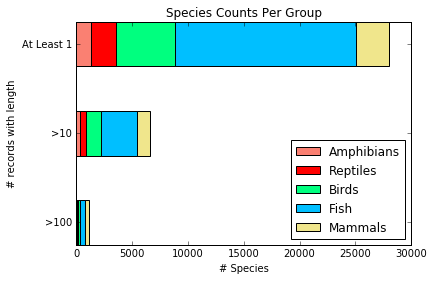

In [19]:
if RUN['Plot Summaries']:
    n = df.shape[0] - 2
    left = [0.0, 0.0, 0.0]

    fig, ax = plt.subplots()

    for i in range(n):
        values = df.loc[i, ['total_length_100', 'total_length_10', 'total_length_0']]
        label = df.iloc[i, 0]
        ax.barh(np.arange(3), values, 0.5, left=left, label=label, color=COLORS[i])
        left += values

    ax.set_title('Species Counts Per Group')
    ax.legend(loc='lower right')
    ax.set_yticks(np.arange(3) + 0.25)
    ax.set_yticklabels(labels=['>100', '>10', 'At Least 1'])
    ax.set_ylabel('# records with length')
    ax.set_xlabel('# Species')
    plt.show()

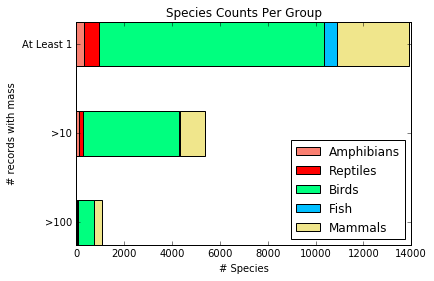

In [20]:
if RUN['Plot Summaries']:
    left = [0.0, 0.0, 0.0]
    n = df.shape[0] - 2
    fig, ax = plt.subplots()

    for i in range(n):
        values = df.loc[i, ['body_mass_100', 'body_mass_10', 'body_mass_0']]
        label = df.iloc[i, 0]
        ax.barh(np.arange(3), values, 0.5, left=left, label=label, color=COLORS[i])
        left += values

    ax.set_title('Species Counts Per Group')
    ax.legend(loc='lower right')
    ax.set_yticks(np.arange(3) + 0.25)
    ax.set_yticklabels(labels=['>100', '>10', 'At Least 1'])
    ax.set_ylabel('# records with mass')
    ax.set_xlabel('# Species')
    plt.show()

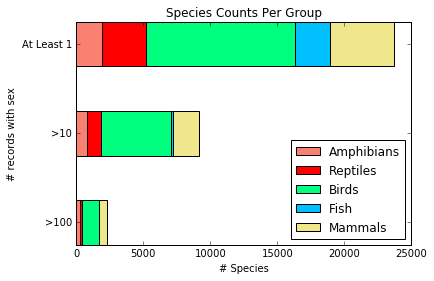

In [26]:
if RUN['Plot Summaries']:
    left = [0.0, 0.0, 0.0]
    n = df.shape[0] - 2
    fig, ax = plt.subplots()

    for i in range(n):
        values = df.loc[i, ['sex_100', 'sex_10', 'sex_0']]
        label = df.iloc[i, 0]
        ax.barh(np.arange(3), values, 0.5, left=left, label=label, color=COLORS[i])
        left += values

    ax.set_title('Species Counts Per Group')
    ax.legend(loc='lower right')
    ax.set_yticks(np.arange(3) + 0.25)
    ax.set_yticklabels(labels=['>100', '>10', 'At Least 1'])
    ax.set_ylabel('# records with sex')
    ax.set_xlabel('# Species')
    plt.show()

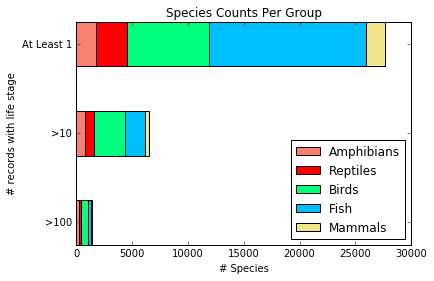

In [27]:
if RUN['Plot Summaries']:
    left = [0.0, 0.0, 0.0]
    n = df.shape[0] - 2
    fig, ax = plt.subplots()

    for i in range(n):
        values = df.loc[i, ['life_stage_100', 'life_stage_10', 'life_stage_0']]
        label = df.iloc[i, 0]
        ax.barh(np.arange(3), values, 0.5, left=left, label=label, color=COLORS[i])
        left += values

    ax.set_title('Species Counts Per Group')
    ax.legend(loc='lower right')
    ax.set_yticks(np.arange(3) + 0.25)
    ax.set_yticklabels(labels=['>100', '>10', 'At Least 1'])
    ax.set_ylabel('# records with life stage')
    ax.set_xlabel('# Species')
    plt.show()

### Plot the Summaries as Pie charts

In [21]:
def make_autopct(values):
    def pie_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{:,}'.format(val, grouping=True)
    return pie_autopct

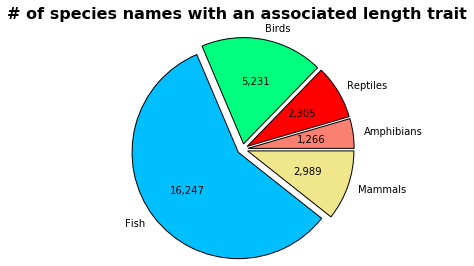

In [22]:
if RUN['Plot Summaries']:
    values = df.loc[0:4, 'total_length_0']
    labels = df.loc[0:4, 'group']
    n = values.size
    plt.suptitle('# of species names with an associated length trait', fontsize=16, weight='semibold', y=1)
    plt.pie(values, labels=labels, colors=COLORS, explode=np.array([0.05] * n), autopct=make_autopct(values))
    plt.axis('equal')
    plt.show()

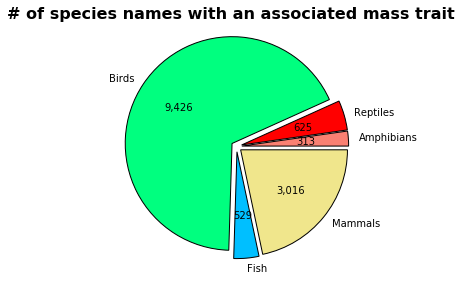

In [23]:
if RUN['Plot Summaries']:
    values = df.loc[0:4, 'body_mass_0']
    labels = df.loc[0:4, 'group']
    plt.suptitle('# of species names with an associated mass trait', fontsize=16, weight='semibold', y=1)
    plt.pie(values, labels=labels, colors=COLORS, explode=np.array([0.05] * n), autopct=make_autopct(values))
    plt.axis('equal')
    plt.show()

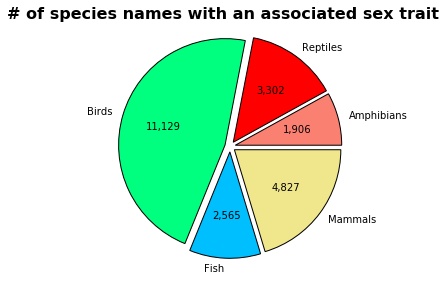

In [24]:
if RUN['Plot Summaries']:
    values = df.loc[0:4, 'sex_0']
    labels = df.loc[0:4, 'group']
    plt.suptitle('# of species names with an associated sex trait', fontsize=16, weight='semibold', y=1)
    plt.pie(values, labels=labels, colors=COLORS, explode=np.array([0.05] * n), autopct=make_autopct(values))
    plt.axis('equal')
    plt.show()

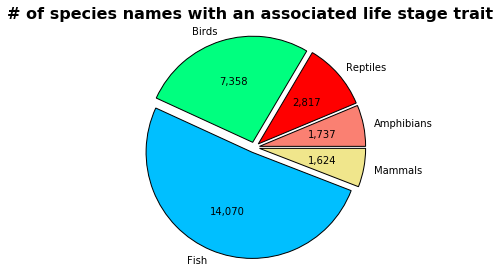

In [25]:
if RUN['Plot Summaries']:
    values = df.loc[0:4, 'life_stage_0']
    labels = df.loc[0:4, 'group']
    plt.suptitle('# of species names with an associated life stage trait', fontsize=16, weight='semibold', y=1)
    plt.pie(values, labels=labels, colors=COLORS, explode=np.array([0.05] * n), autopct=make_autopct(values))
    plt.axis('equal')
    plt.show()

[top](#Table-of-Contents)